## Hospital Admissions Dataset

The hospital admissions dataset contains information about patients admitted to Hero DMC Heart Institute, Unit of Dayanand Medical College and Hospital in Ludhiana, Punjab, India over a period of two years. The cardiology unit had 14,845 admissions corresponding to 12,238 patients, of which 1921 had multiple admissions. The dataset includes patient demographics, patient history, medical conditions, and outcomes indicating whether the patient was discharged or expired in the hospital. We want to explore the relationship between patient demographics, medical conditions, duration of hospital stay, and predict outcomes of patient discharge or expiry. We wanted to explore questions such as, "is there a relationship between certain patient demographics (age, gender, etc.) and duration of hospital stay?" and, "what are the most influential predictors for patient outcome at the time of admission?"

In [1]:
#You should submit a report describing your work. The length of the report should approximately be 10 pages. 
#The report and your work can also be all in a jupyter notebook, which you submit along with your data

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

random.seed(42)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/kateue/hospital_admission/main/HDHI%20Admission%20data.csv')


In [3]:
col_names = df.keys()

#lower case columns
col_names = [x.lower() for x in col_names]
df.set_axis(col_names, axis=1, inplace = True)
df.head(5)

sno mrd no.     d.o.a      d.o.d  age gender rural  \
0    1  234735  4/1/2017   4/3/2017   81      M     R   
1    2  234696  4/1/2017   4/5/2017   65      M     R   
2    3  234882  4/1/2017   4/3/2017   53      M     U   
3    4  234635  4/1/2017   4/8/2017   67      F     U   
4    5  234486  4/1/2017  4/23/2017   60      F     U   

  type of admission-emergency/opd month year  duration of stay  ...  \
0                               E     Apr-17                 3  ...   
1                               E     Apr-17                 5  ...   
2                               E     Apr-17                 3  ...   
3                               E     Apr-17                 8  ...   
4                               E     Apr-17                23  ...   

   congenital uti  neuro cardiogenic syncope  orthostatic  \
0           0   0                          0            0   
1           0   0                          0            0   
2           0   0                          0            0   
3           0   0                          0            0   
4           0   0                          0            0   

   infective endocarditis  dvt  cardiogenic shock  shock  pulmonary embolism  \
0                       0    0                  0      0                   0   
1                       0    0                  0      0                   0   
2                       0    0                  0      0                   0   
3                       0    0                  0      0                   0   
4                       0    0                  0      0                   0   

  chest infection  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 56 columns]

In [4]:
#drop features that may have no use (edit as needed)
unneeded_features = ["sno", "mrd no.", "d.o.a", "month year"]
if "sno" in df.keys():
    df.drop(unneeded_features, axis = 1, inplace = True)

# if "shock" in df.keys():
# df.drop(["shock"], axis = 1, inplace = True)

In [5]:
#either do this or replace with mean/median of column. Could drop col like below
#make a simpleImputer and find numerical and categorical columns, and then make a pipeline

df.fillna(0, inplace = True)
df.replace("EMPTY", 0, inplace = True)

In [6]:
#clean names so they are more clear

unclear_feats = ["d.o.d", "dm", "htn", "cad", "prior cmp","ckd", "ef", "tlc", "bnp", "stemi", "hfref", "hfnef", "chb", "sss",
                    "aki","cva infract", "cva bleed", "af", "vt", "psvt", "uti", "dvt", 'hb', 'acs']

clear_feats = ["date of departure", "diabetes mellitus", "hypertension", "coronary artery disease", "prior metabolic panel",
                  "chronic kidney disease","ejection fraction", "leucocyte count", "brain natriuretic peptide", 
                  "myocardial infarction", "heart failure w/ reduced ejection","heart failure w/ normal ejection", "complete heart block", 
                  "sick sinus", "kidney injury", "cerebrovascular accident", "cerebrovascular accident",
                  "atrial fibrillation","ventricular tachycardia", "paroxysmal tachycardia",
                  "urinary tract infections", "vein thrombosis", 'haemoglobin','acute coronary syndrome']

for i in range(len(unclear_feats)):
    df.rename(columns = {unclear_feats[i] : clear_feats[i]}, inplace = True)


print("Features:\n ")
print(df.keys())
print("\nTotal features: ", len(df.keys()))

Features:
 
Index(['date of departure', 'age', 'gender', 'rural',
       'type of admission-emergency/opd', 'duration of stay',
       'duration of intensive unit stay', 'outcome', 'smoking ', 'alcohol',
       'diabetes mellitus', 'hypertension', 'coronary artery disease',
       'prior metabolic panel', 'chronic kidney disease', 'haemoglobin',
       'leucocyte count', 'platelets', 'glucose', 'urea', 'creatinine',
       'brain natriuretic peptide', 'raised cardiac enzymes',
       'ejection fraction', 'severe anaemia', 'anaemia', 'stable angina',
       'acute coronary syndrome', 'myocardial infarction',
       'atypical chest pain', 'heart failure',
       'heart failure w/ reduced ejection', 'heart failure w/ normal ejection',
       'valvular', 'complete heart block', 'sick sinus', 'kidney injury',
       'cerebrovascular accident', 'cerebrovascular accident',
       'atrial fibrillation', 'ventricular tachycardia',
       'paroxysmal tachycardia', 'congenital', 'urinary tract in

In [7]:
df.describe()

age  duration of stay  duration of intensive unit stay  \
count  15757.000000      15757.000000                      15757.00000   
mean      61.426160          6.415054                          3.80377   
std       13.420862          5.011421                          4.01564   
min        4.000000          1.000000                          0.00000   
25%       54.000000          3.000000                          1.00000   
50%       62.000000          5.000000                          3.00000   
75%       70.000000          8.000000                          5.00000   
max      110.000000         98.000000                         58.00000   

           smoking        alcohol  diabetes mellitus  hypertension  \
count  15757.000000  15757.000000       15757.000000  15757.000000   
mean       0.050327      0.064797           0.323475      0.485879   
std        0.218625      0.246174           0.467817      0.499816   
min        0.000000      0.000000           0.000000      0.000000   
25%        0.000000      0.000000           0.000000      0.000000   
50%        0.000000      0.000000           0.000000      0.000000   
75%        0.000000      0.000000           1.000000      1.000000   
max        1.000000      1.000000           1.000000      1.000000   

       coronary artery disease  prior metabolic panel  chronic kidney disease  \
count             15757.000000           15757.000000            15757.000000   
mean                  0.669607               0.154471                0.098369   
std                   0.470369               0.361411                0.297822   
min                   0.000000               0.000000                0.000000   
25%                   0.000000               0.000000                0.000000   
50%                   1.000000               0.000000                0.000000   
75%                   1.000000               0.000000                0.000000   
max                   1.000000               1.000000                1.000000   

       ...  paroxysmal tachycardia    congenital  urinary tract infections  \
count  ...            15757.000000  15757.000000              15757.000000   
mean   ...                0.007552      0.010472                  0.061877   
std    ...                0.086577      0.101797                  0.240940   
min    ...                0.000000      0.000000                  0.000000   
25%    ...                0.000000      0.000000                  0.000000   
50%    ...                0.000000      0.000000                  0.000000   
75%    ...                0.000000      0.000000                  0.000000   
max    ...                1.000000      1.000000                  1.000000   

       neuro cardiogenic syncope   orthostatic  infective endocarditis  \
count               15757.000000  15757.000000            15757.000000   
mean                    0.008377      0.007870                0.001840   
std                     0.091146      0.088363                0.042862   
min                     0.000000      0.000000                0.000000   
25%                     0.000000      0.000000                0.000000   
50%                     0.000000      0.000000                0.000000   
75%                     0.000000      0.000000                0.000000   
max                     1.000000      1.000000                1.000000   

       vein thrombosis  cardiogenic shock         shock  pulmonary embolism  
count     15757.000000       15757.000000  15757.000000        15757.000000  
mean          0.013264           0.059910      0.046646            0.015358  
std           0.114406           0.237327      0.210886            0.122977  
min           0.000000           0.000000      0.000000            0.000000  
25%           0.000000           0.000000      0.000000            0.000000  
50%           0.000000           0.000000      0.000000            0.000000  
75%           0.000000           0.000000      0.000000            0.000

<AxesSubplot: >

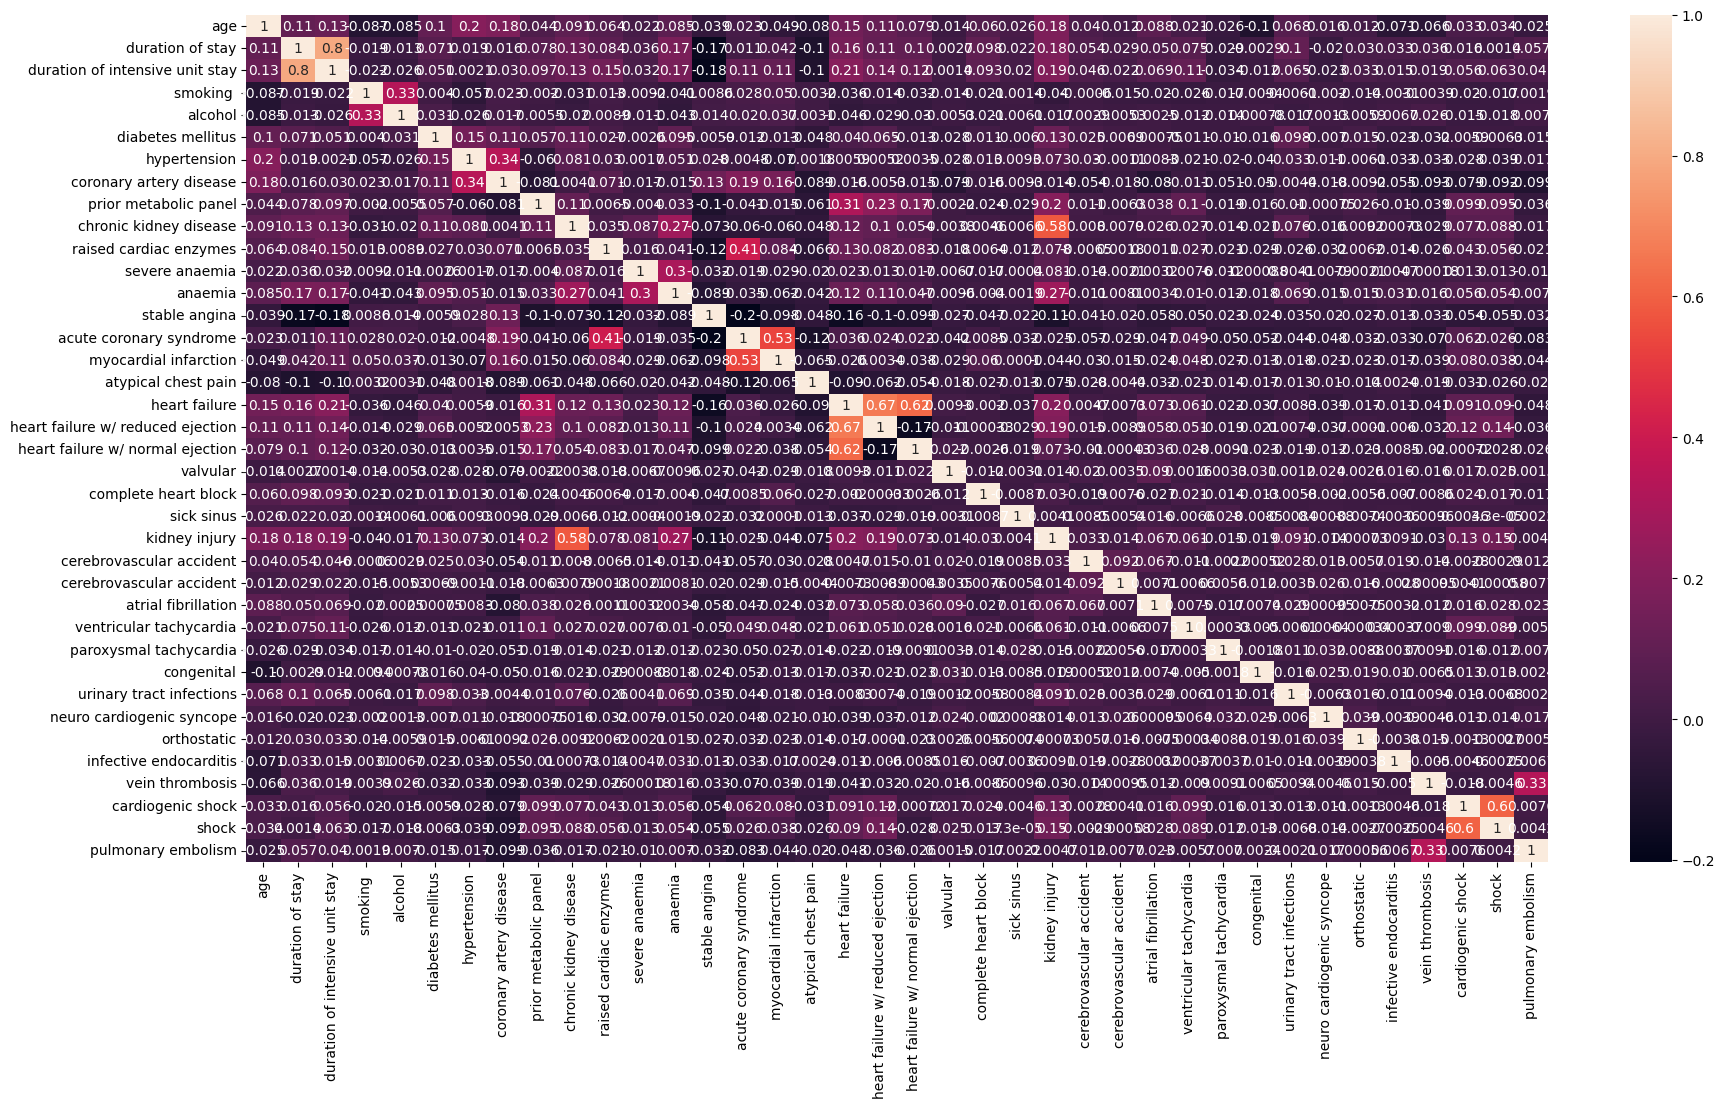

In [8]:
plt.figure(figsize = (21, 11))
correlation = df.corr()
sns.heatmap(correlation, annot = True)


Text(0, 0.5, 'frequency')

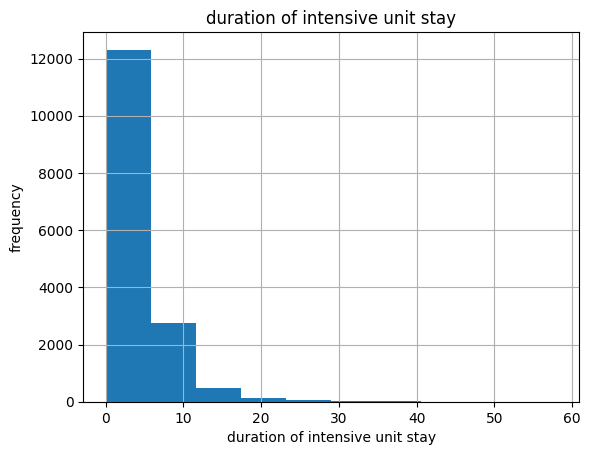

In [9]:
df.hist('duration of intensive unit stay')
plt.xlabel('duration of intensive unit stay')
plt.ylabel('frequency') 

In [10]:
#this should be piplined instead #todo
#normalize features
norm_feats = ["haemoglobin", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide",
           "ejection fraction", "duration of intensive unit stay"]

#pipeline
norm_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

df[norm_feats] = norm_pipeline.fit_transform(df[norm_feats])
           
#keep old values if needed later
o_vals =  []
norm_vals = []
#minmax_normalizer = MinMaxScaler() #use standardScaler instead?

#for i in range(len(norm_feats)):

    #o_vals.append(df[norm_feats[i]].values)

    #norm_temp = minmax_normalizer.fit_transform(df[norm_feats[i]].astype("float64").values.reshape(-1,1))

    #norm_vals.append(norm_temp.copy())
    #df[norm_feats[i]] = norm_temp.copy()



Text(0, 0.5, 'frequency')

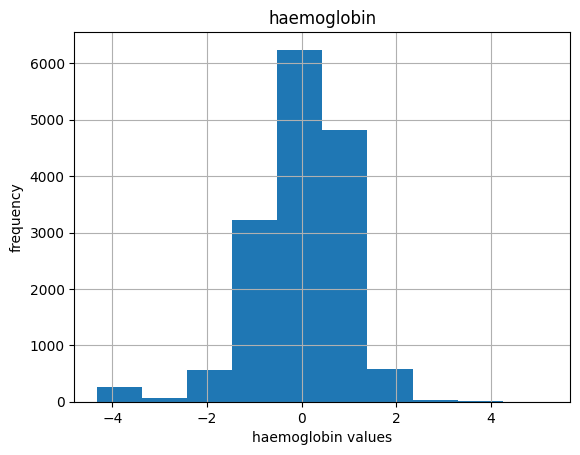

In [11]:
df.hist('haemoglobin')
plt.xlabel('haemoglobin values')
plt.ylabel('frequency') 

## Evaluating Performance of Dummy Regressor Model

Here we built a dummy regressor model that predicts the duration of hospital stay on several features including, haemoglobin, leucocyte count, platelets, and more. The purpose is to establish a baseline model for predicting the duration of stay at a hospital. The model is evaluated using cross validation with 10 folds, and we calculate the training and testing average cross validation, and the error margin. The difference between the predicted and true values for each mean and median strategies were plotted using a scatter plot and the cross validation scores were plotted for both the training and testing sets. 

Training Average CV Score:  5.024434685502248
Testing Average CV Score:  5.024434685502248
Error Margin with mean Strategy:  24.541942908715786


Training Average CV Score:  5.224496945730927
Testing Average CV Score:  5.224496945730927
Error Margin with median Strategy:  26.38219120135364




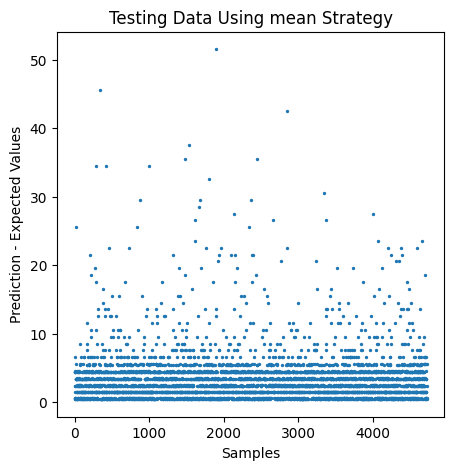

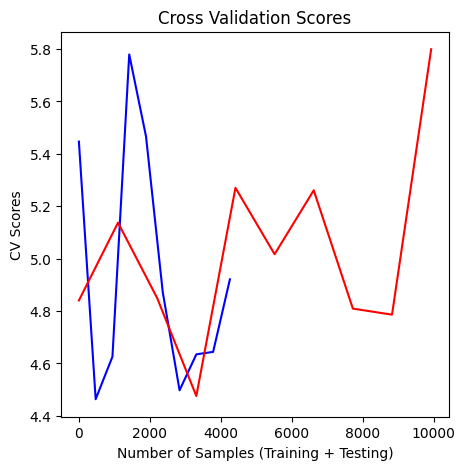

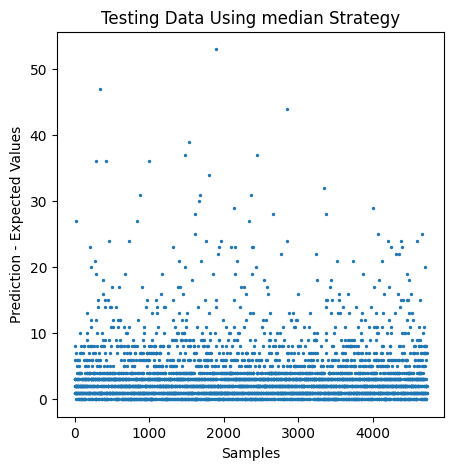

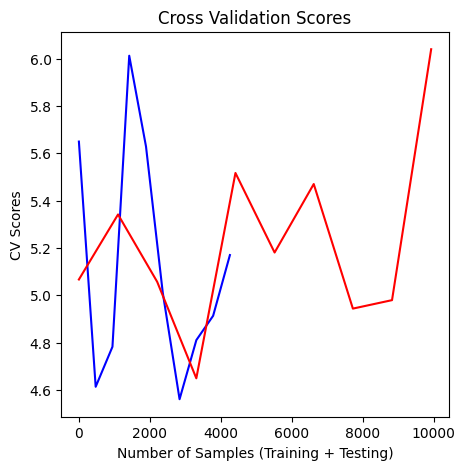

In [12]:
#Dummy Regressor to predict length of stay at a hospital as baseline
#pipeline #todo

label = "duration of stay"
features = ["haemoglobin", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide"]
strategies = ["mean", "median"]
predictions = []
training_scores = []
testing_scores = []

# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(df[features].values, df[label].values, test_size = 0.3,\
                                                    random_state = 42)

# pipeline
pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

train_x = pipeline.fit_transform(train_x)
test_x = pipeline.transform(test_x)

# dummy regressor and eval performance using cross val 
for strat in strategies:
    
    dummy_classifier = DummyRegressor(strategy = strat)
    result = dummy_classifier.fit(train_x, train_y)
    prediction = result.predict(test_x)
    predictions.append(prediction)

    train_cv_score = -cross_val_score(dummy_classifier, train_x, train_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)

    print("Training Average CV Score: ", np.average(train_cv_score))


    testing_cv_score = -cross_val_score(dummy_classifier, test_x, test_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)

    print("Testing Average CV Score: ", np.average(train_cv_score))
    print(f"Error Margin with {strat} Strategy: ", mean_squared_error(prediction, test_y))
    print("\n")
    

    training_scores.append(train_cv_score.copy())
    testing_scores.append(testing_cv_score.copy())


# Plotting difference between predictions and true values
for i in range(len(predictions)):
    plt.subplots(1, figsize = (5,5))
    plt.title(f"Testing Data Using {strategies[i]} Strategy")
    plt.xlabel("Samples")
    plt.ylabel("Prediction - Expected Values")
    plt.scatter(np.arange(0, len(predictions[i])) ,abs(predictions[i] - test_y), s = 2)

    plt.subplots(1, figsize = (5,5))
    plt.title("Cross Validation Scores")
    plt.ylabel("CV Scores")
    plt.xlabel("Number of Samples (Training + Testing)")
    plt.plot(np.arange(0, len(test_x), len(test_x)/len(testing_scores[i])) , testing_scores[i], color = "blue")
    plt.plot(np.arange(0, len(train_x), len(train_x)/len(training_scores[i])) , training_scores[i], color = "red")
    plt.plot()

The training cross validation scores, testing cross validation scores, and the error margins suggests that the mean strategy performs slightly better than the median strategy. 

## Predicting Duration of Stay at the Hospital with Linear Regression

Here we build a linear regression model to predict the duration of stay at the hospital, using mean squared error as an evaluation metric, and the model's performance is assessed using cross validation. The lower cross validation scores suggest that the model performs reasonably well in predicting the duration of stay at the hospital. The difference between the predicted and true values were plotted using a scatter plot and the cross validation scores were plotted for both the training and testing data. 

Training Average CV Score:  4.837467461184595
Training Error Margin with Solver:  23.444201257003034


Testing Average CV Score:  4.705919510064705
Testing Error Margin:  22.189383490755453




[]

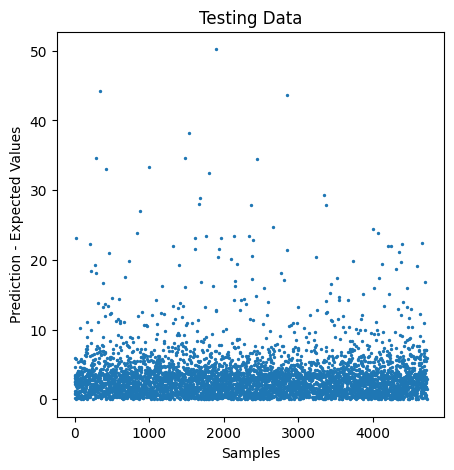

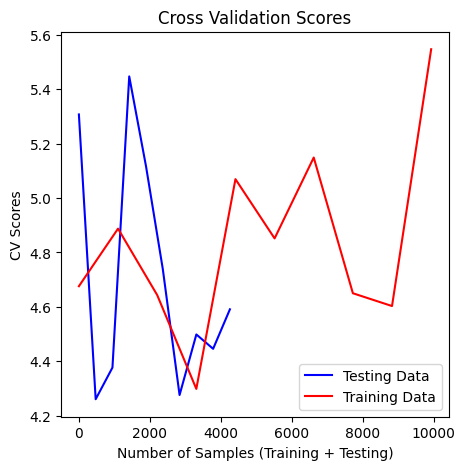

In [13]:
#Linear Regression model to predict the length of stay at the hospital

linear_regression = LinearRegression(fit_intercept = True, n_jobs = -1)
result = linear_regression.fit(train_x, train_y)
prediction_tr = result.predict(train_x)
prediction_te = result.predict(test_x)

train_cv_score = -cross_val_score(linear_regression, train_x, train_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)

print("Training Average CV Score: ", np.average(train_cv_score))
print("Training Error Margin with Solver: ", mean_squared_error(prediction_tr, train_y))

print("\n")

testing_cv_score = -cross_val_score(linear_regression, test_x, test_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)

print("Testing Average CV Score: ", np.average(testing_cv_score))
print("Testing Error Margin: ", mean_squared_error(prediction_te, test_y))
print("\n")
  

#Plotting difference between testing predictions and true values

plt.subplots(1, figsize = (5,5))
plt.title(f"Testing Data")
plt.xlabel("Samples")
plt.ylabel("Prediction - Expected Values")
plt.scatter(np.arange(0, len(prediction_te)) ,abs(prediction_te - test_y), s = 2)

plt.subplots(1, figsize = (5,5))
plt.title("Cross Validation Scores")
plt.ylabel("CV Scores")
plt.xlabel("Number of Samples (Training + Testing)")
plt.plot(np.arange(0, len(test_x), len(test_x)/len(testing_cv_score)) , testing_cv_score, color = "blue", label = "Testing Data")
plt.plot(np.arange(0, len(train_x), len(train_x)/len(train_cv_score)) , train_cv_score, color = "red", label = "Training Data")
plt.legend()
plt.plot()

## Random Forest Regression

Here we are using different numbers of estimators to fit the model. For each value of the estimator, we compute the cross validation score for the training and test data to evaluate the accuracy of the model, as well as the error margin between the predicted and expected values. The testing data is plotted for each value of the estimators to visualize the predicted values compared to the expected values. 

Training Average CV Score:  0.11370653336480414
Training Error Margin with Solver:  7.269741271759348


Testing Average CV Score:  0.07015082047744217
Testing Error Margin:  21.18410040078216


Training Average CV Score:  0.1308769479919755
Training Error Margin with Solver:  6.9703929266346165


Testing Average CV Score:  0.0808168415702166
Testing Error Margin:  20.896539510350195


Training Average CV Score:  0.13807960293087812
Training Error Margin with Solver:  6.875210204326948


Testing Average CV Score:  0.08884654291505546
Testing Error Margin:  20.78377255516855


Training Average CV Score:  0.14198709306748455
Training Error Margin with Solver:  6.885558079490599


Testing Average CV Score:  0.09164124608957579
Testing Error Margin:  20.567439185677895


Training Average CV Score:  0.1439343882895058
Training Error Margin with Solver:  6.865101319120443


Testing Average CV Score:  0.09328914860586796
Testing Error Margin:  20.551146002347217


Training Average CV Score:  0

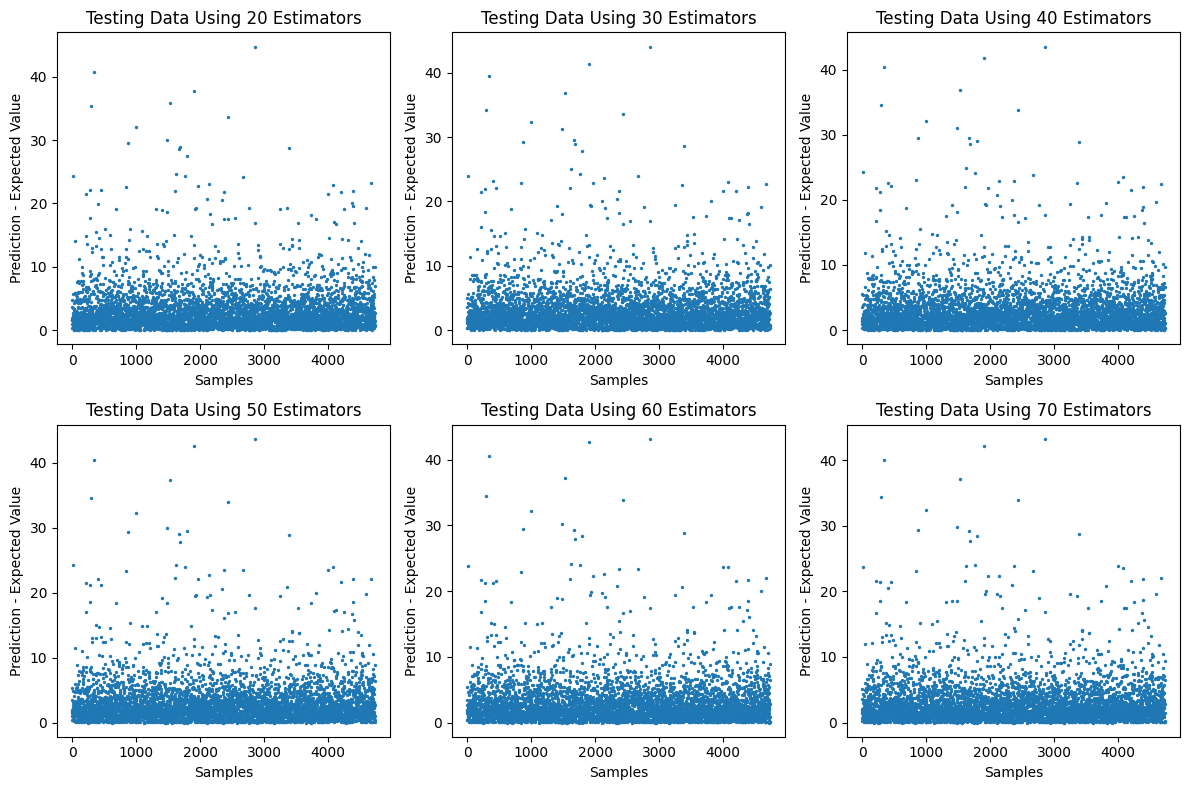

In [14]:
# Random Forest Regression

estimators =[20,30,40,50,60,70]

predictions = []
training_scores = []
testing_scores = []
test_predicts = []
for x in estimators:
        
    forest_reg = RandomForestRegressor(n_estimators = x, max_depth = 15, n_jobs = -1, random_state = 42)
    for_fit = forest_reg.fit(train_x, train_y)
    prediction_tr = for_fit.predict(train_x).astype("float64")
    prediction_te = for_fit.predict(test_x).astype("float64")

    #train_cv_score = -cross_val_score(forest_reg, train_x, train_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)
    #testing_cv_score = -cross_val_score(forest_reg, test_x, test_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)

    train_cv_score = cross_val_score(forest_reg, train_x, train_y, n_jobs = -1, cv = 10)
    testing_cv_score = cross_val_score(forest_reg, test_x, test_y, n_jobs = -1, cv = 10)


    training_scores.append(train_cv_score.copy())
    testing_scores.append(testing_cv_score.copy())
    test_predicts.append(prediction_te)

    print("Training Average CV Score: ", np.average(train_cv_score))
    print("Training Error Margin with Solver: ", mean_squared_error(prediction_tr, train_y))
    print("\n")
    
    print("Testing Average CV Score: ", np.average(testing_cv_score))
    print("Testing Error Margin: ", mean_squared_error(prediction_te, test_y))
    print("\n")

#for i in range(len(test_predicts)): #how to make as a grid for images?
        #plt.subplots(1, figsize = (5,5))
        #plt.xlabel("Samples")
        #plt.ylabel("Prediction - Expected Value")
        #plt.title(f"Testing Data Using {estimators[i]} Estimators")
        #plt.scatter(np.arange(0, len(test_predicts[i])), abs(test_predicts[i] - test_y), s=2)

fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

for i in range(len(test_predicts)):
    row = i // 3
    col = i % 3

    subplot = subplots[row, col]
    subplot.scatter(np.arange(0, len(test_predicts[i])), 
    abs(test_predicts[i]-test_y), s=2)
    subplot.set_xlabel("Samples")
    subplot.set_ylabel("Prediction - Expected Value")
    subplot.set_title(f"Testing Data Using {estimators[i]} Estimators")

plt.tight_layout()
plt.show()




We see that the training and testing scores increase as the value of estimators increase and the error margins decrease. This suggests that increasing the value of estimators can improve the performance of the model. 

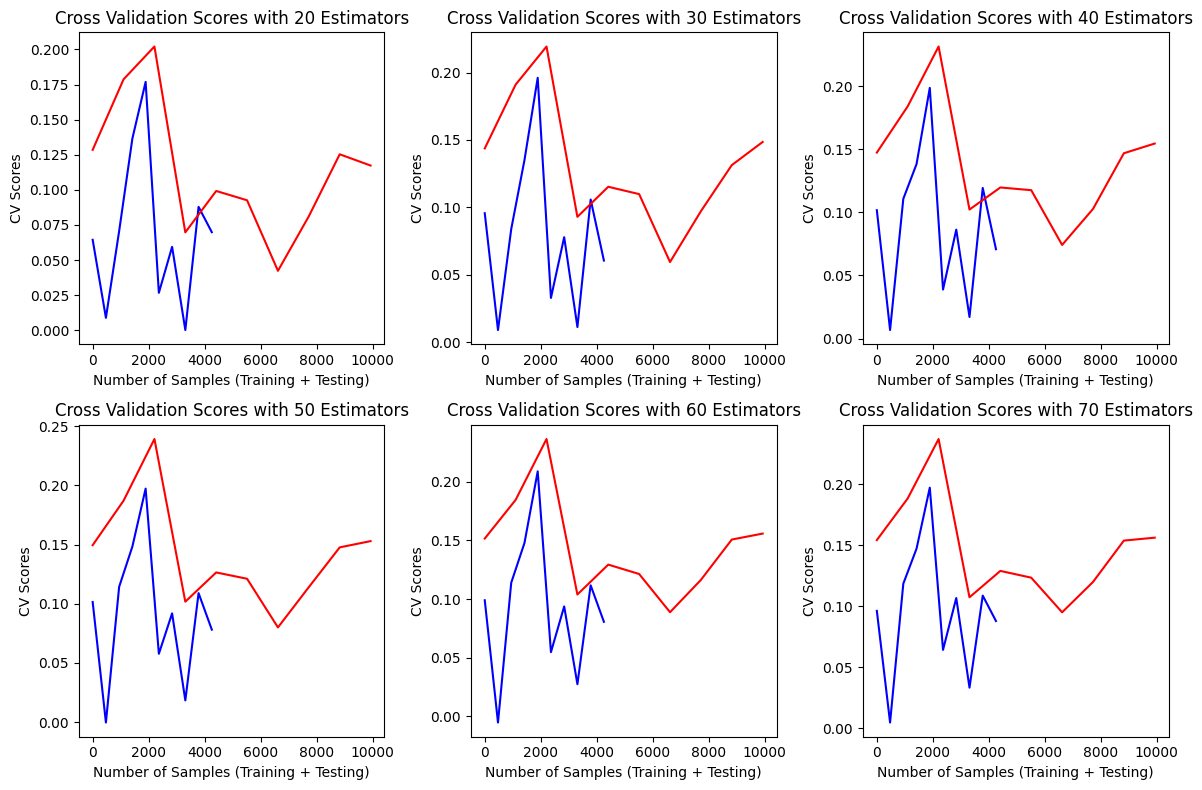

In [15]:
fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

for i in range(len(testing_scores)):
    row = i // 3
    col = i % 3

    subplot = subplots[row, col]
    subplot.plot(np.arange(0, len(test_x), len(test_x)/len(testing_scores[i])) , testing_scores[i], color = "blue")
    subplot.plot(np.arange(0, len(train_x), len(train_x)/len(training_scores[i])) , training_scores[i], color = "red")
    subplot.set_xlabel("Number of Samples (Training + Testing)")
    subplot.set_ylabel("CV Scores")
    subplot.set_title(f"Cross Validation Scores with {estimators[i]} Estimators")

plt.tight_layout()
plt.show()

## Improving Predictions in the Random Forest Regression 

Here we are expanding features in the Random Forest Regression model to try to get a better prediction. We find that this model performs better, as it has a higher training cross validation score and a lower error margin than before. 

Training Average CV Score Using 20 Estimators:  0.6368101679329096
Training Error Margin Using 20 Estimators:  3.0479290655400146

Testing Average CV Score Using 20 Estimators:  0.6026597168210343
Testing Error Margin Using 20 Estimators:  9.314221833394736


Training Average CV Score Using 30 Estimators:  0.6407425812574085
Training Error Margin Using 30 Estimators:  3.016166560313378

Testing Average CV Score Using 30 Estimators:  0.605774183525858
Testing Error Margin Using 30 Estimators:  9.144712956457093


Training Average CV Score Using 40 Estimators:  0.6436844177269923
Training Error Margin Using 40 Estimators:  2.9529704143049775

Testing Average CV Score Using 40 Estimators:  0.6080989474838027
Testing Error Margin Using 40 Estimators:  9.129806486253612


Training Average CV Score Using 50 Estimators:  0.6452454207301356
Training Error Margin Using 50 Estimators:  2.951758224690756

Testing Average CV Score Using 50 Estimators:  0.6105728151098189
Testing Error Margin Using

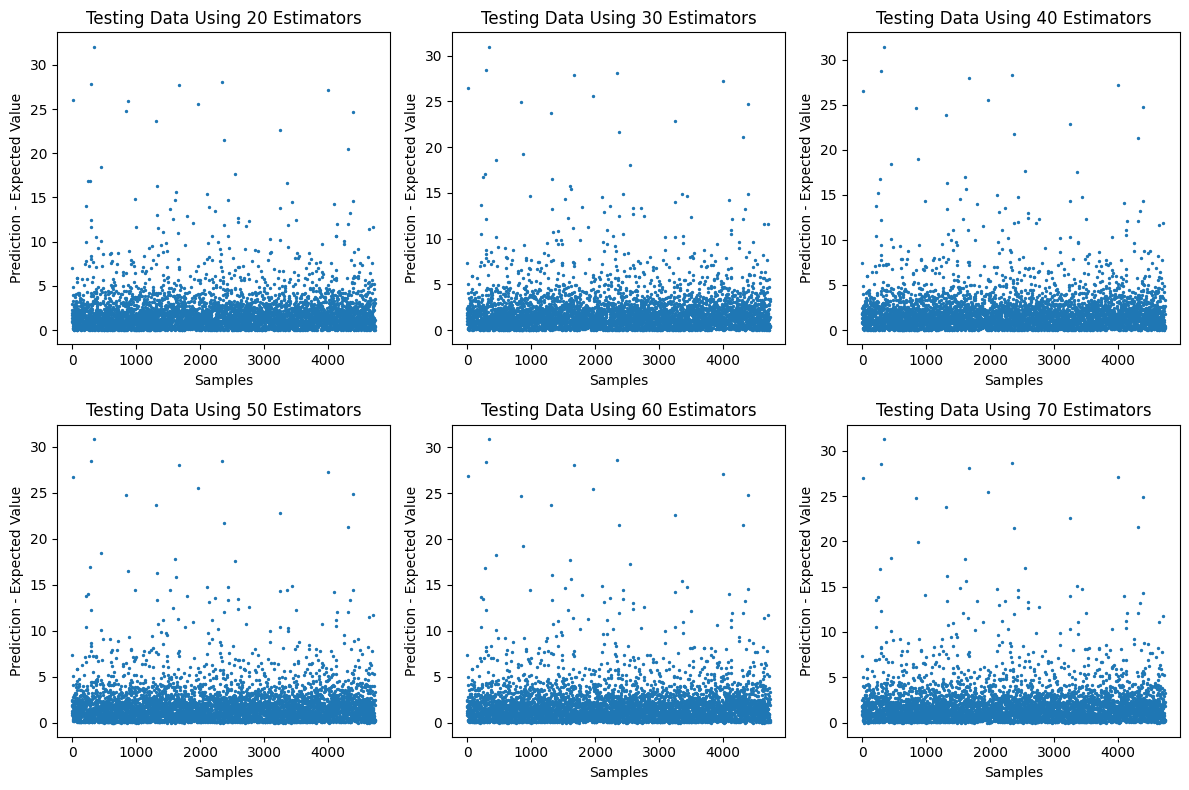

In [16]:
#my plan is to expand features in model to try and get a better prediciton

label = "duration of stay"

#time can be spent here finding optimal features
features = ["haemoglobin","leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide", "smoking ", 
           "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
           "heart failure", "complete heart block", "sick sinus", "kidney injury", "cerebrovascular accident",
           "atrial fibrillation", "ventricular tachycardia", "hypertension","coronary artery disease", "chronic kidney disease"
           ,"duration of intensive unit stay", "age", "diabetes mellitus"]

train_x, test_x, train_y, test_y = train_test_split(df[features].values, df[label].values, test_size = 0.3,\
                                                    random_state = 42)

'''
for reference, remove at some point
['date of departure', 'age', 'gender', 'rural',
       'type of admission-emergency/opd', 'duration of stay',
       'duration of intensive unit stay', 'outcome', 'smoking ', 'alcohol',
       'diabetes mellitus', 'hypertension', 'coronary artery disease',
       'prior metabolic panel', 'chronic kidney disease', 'haemoglobin',
       'leucocyte count', 'platelets', 'glucose', 'urea', 'creatinine',
       'brain natriuretic peptide', 'raised cardiac enzymes',
       'ejection fraction', 'severe anaemia', 'anaemia', 'stable angina',
       'acute coronary syndrome', 'myocardial infarction',
       'atypical chest pain', 'heart failure',
       'heart failure w/ reduced ejection', 'heart failure w/ normal ejection',
       'valvular', 'complete heart block', 'sick sinus', 'kidney injury',
       'cerebrovascular accident', 'cerebrovascular accident',
       'atrial fibrillation', 'ventricular tachycardia',
       'paroxysmal tachycardia', 'congenital', 'urinary tract infections',
       'neuro cardiogenic syncope', 'orthostatic', 'infective endocarditis',
       'vein thrombosis', 'cardiogenic shock', 'shock', 'pulmonary embolism',
       'chest infection'],
'''

#Random Forest Regression
estimators =[20,30,40,50,60,70]

predictions = []
training_scores = []
testing_scores = []
test_predicts = []
for x in estimators:
        
    forest_reg = RandomForestRegressor(n_estimators = x, max_depth = 15, n_jobs = -1, random_state = 42)
    for_fit = forest_reg.fit(train_x, train_y)
    prediction_tr = for_fit.predict(train_x).astype("float64")
    prediction_te = for_fit.predict(test_x).astype("float64")

    #train_cv_score = -cross_val_score(forest_reg, train_x, train_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)
    #testing_cv_score = -cross_val_score(forest_reg, test_x, test_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)

    train_cv_score = cross_val_score(forest_reg, train_x, train_y, n_jobs = -1, cv = 10)
    testing_cv_score = cross_val_score(forest_reg, test_x, test_y, n_jobs = -1, cv = 10)


    training_scores.append(train_cv_score.copy())
    testing_scores.append(testing_cv_score.copy())
    test_predicts.append(prediction_te)

    print(f"Training Average CV Score Using {x} Estimators: ", np.average(train_cv_score))
    print(f"Training Error Margin Using {x} Estimators: ", mean_squared_error(prediction_tr, train_y))
    print()
    
    print(f"Testing Average CV Score Using {x} Estimators: ", np.average(testing_cv_score))
    print(f"Testing Error Margin Using {x} Estimators: ", mean_squared_error(prediction_te, test_y))
    print("\n")

fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

for i in range(len(test_predicts)):
    row = i // 3
    col = i % 3

    subplot = subplots[row, col]
    subplot.scatter(np.arange(0, len(test_predicts[i])), 
    abs(test_predicts[i]-test_y), s=2)
    subplot.set_xlabel("Samples")
    subplot.set_ylabel("Prediction - Expected Value")
    subplot.set_title(f"Testing Data Using {estimators[i]} Estimators")

plt.tight_layout()
plt.show()

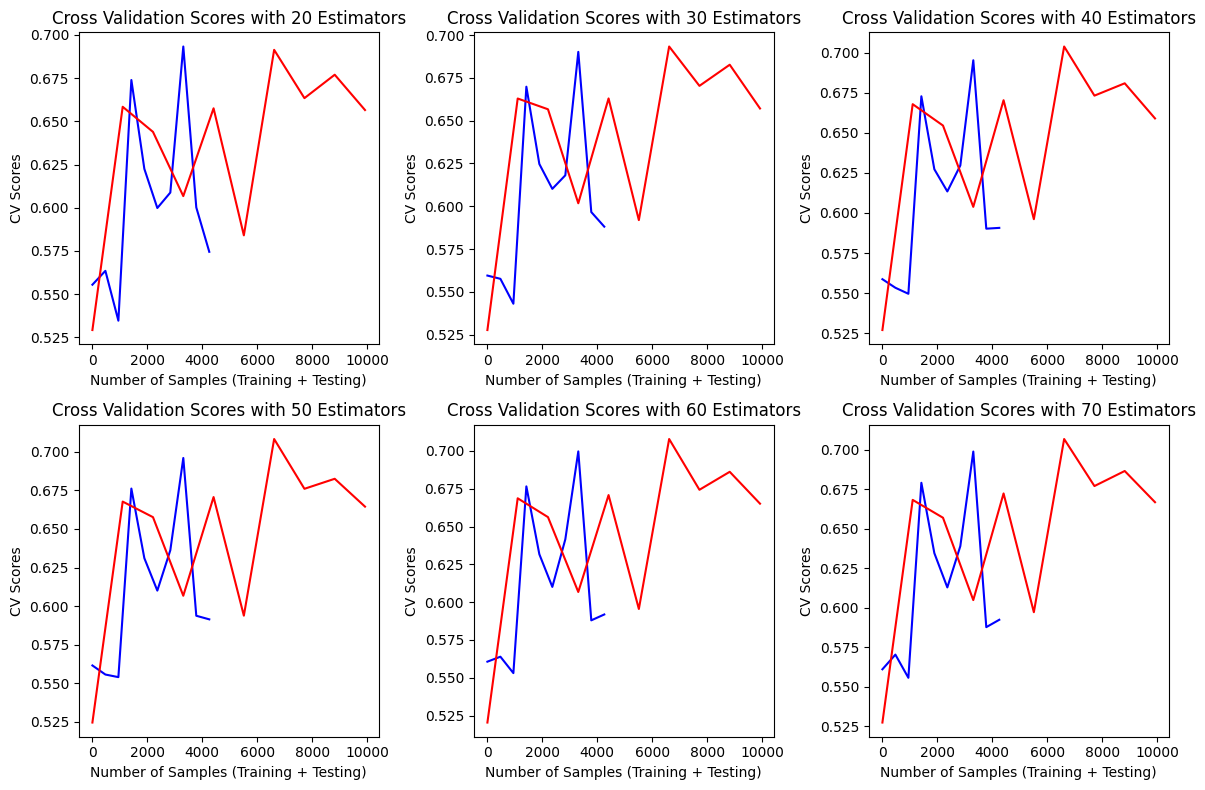

In [17]:
fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

for i in range(len(testing_scores)):
    row = i // 3
    col = i % 3

    subplot = subplots[row, col]
    subplot.plot(np.arange(0, len(test_x), len(test_x)/len(testing_scores[i])) , testing_scores[i], color = "blue")
    subplot.plot(np.arange(0, len(train_x), len(train_x)/len(training_scores[i])) , training_scores[i], color = "red")
    subplot.set_xlabel("Number of Samples (Training + Testing)")
    subplot.set_ylabel("CV Scores")
    subplot.set_title(f"Cross Validation Scores with {estimators[i]} Estimators")

plt.tight_layout()
plt.show()


The CV scores did improve dramatically, from around 10% to ~61% for the testing data. The extra features added, such as "duration of intensive unit stay", had a significant effect on the model and are more correlated with the label.

## Bounding 'duration of stay' Label to Reduce Error Margin

min duration: 1
max duration: 98
avg duration: 6.4150536269594465
upper bound 15.0


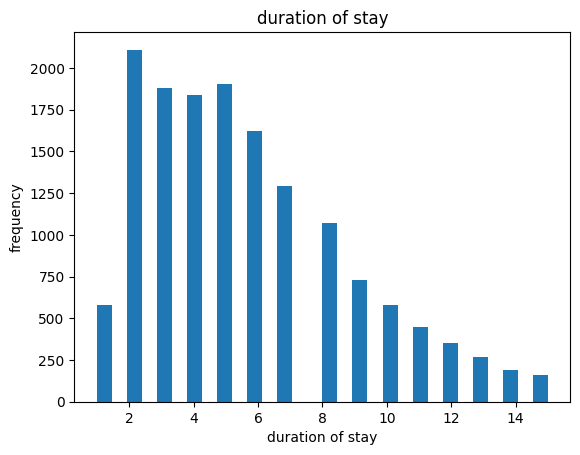

In [18]:
#todo find min, max, average of 'duration of stay' label. Then set an upperbound that is appropriate 
#(ie remove upper outliers) this is to attempt to lower error margin further

# min, max, average of 'duration of stay' label
min_dur = df['duration of stay'].min()
max_dur = df['duration of stay'].max()
avg_dur = df['duration of stay'].mean()
print("min duration:", min_dur)
print("max duration:", max_dur)
print("avg duration:", avg_dur)

# upper bound 
# feel free to change
upperbound = np.percentile(df['duration of stay'], 95)

# remove upper outliers
df_temp = df[df['duration of stay'] <= upperbound]

print("upper bound", upperbound)

plt.hist(df_temp['duration of stay'], bins=30)
plt.xlabel('duration of stay')
plt.ylabel('frequency')
plt.title('duration of stay')
plt.show()

Above shows that the avg duration is about 6.4 days, but the minimum stay and the maximum stay are 1, and 98 respectively. This indicates that there are some outliers in our dataset that can be removed.

In [19]:
df_temp.describe()

age  duration of stay  duration of intensive unit stay  \
count  15021.000000      15021.000000                     15021.000000   
mean      61.292191          5.637175                        -0.125229   
std       13.388830          3.220530                         0.712076   
min        4.000000          1.000000                        -0.947269   
25%       54.000000          3.000000                        -0.698235   
50%       62.000000          5.000000                        -0.200166   
75%       70.000000          8.000000                         0.297902   
max      110.000000         15.000000                         3.037278   

           smoking        alcohol  diabetes mellitus  hypertension  \
count  15021.000000  15021.000000       15021.000000  15021.000000   
mean       0.051328      0.065309           0.319286      0.483923   
std        0.220674      0.247078           0.466216      0.499758   
min        0.000000      0.000000           0.000000      0.000000   
25%        0.000000      0.000000           0.000000      0.000000   
50%        0.000000      0.000000           0.000000      0.000000   
75%        0.000000      0.000000           1.000000      1.000000   
max        1.000000      1.000000           1.000000      1.000000   

       coronary artery disease  prior metabolic panel  chronic kidney disease  \
count             15021.000000           15021.000000            15021.000000   
mean                  0.669995               0.150989                0.091938   
std                   0.470230               0.358050                0.288948   
min                   0.000000               0.000000                0.000000   
25%                   0.000000               0.000000                0.000000   
50%                   1.000000               0.000000                0.000000   
75%                   1.000000               0.000000                0.000000   
max                   1.000000               1.000000                1.000000   

       ...  paroxysmal tachycardia    congenital  urinary tract infections  \
count  ...            15021.000000  15021.000000              15021.000000   
mean   ...                0.007789      0.010452                  0.057852   
std    ...                0.087914      0.101703                  0.233472   
min    ...                0.000000      0.000000                  0.000000   
25%    ...                0.000000      0.000000                  0.000000   
50%    ...                0.000000      0.000000                  0.000000   
75%    ...                0.000000      0.000000                  0.000000   
max    ...                1.000000      1.000000                  1.000000   

       neuro cardiogenic syncope   orthostatic  infective endocarditis  \
count               15021.000000  15021.000000            15021.000000   
mean                    0.008588      0.007656                0.001465   
std                     0.092276      0.087166                0.038244   
min                     0.000000      0.000000                0.000000   
25%                     0.000000      0.000000                0.000000   
50%                     0.000000      0.000000                0.000000   
75%                     0.000000      0.000000                0.000000   
max                     1.000000      1.000000                1.000000   

       vein thrombosis  cardiogenic shock         shock  pulmonary embolism  
count     15021.000000       15021.000000  15021.000000        15021.000000  
mean          0.013248           0.058718      0.045470            0.014513  
std           0.114339           0.235104      0.208339            0.119597  
min           0.000000           0.000000      0.000000            0.000000  
25%           0.000000           0.000000      0.000000            0.000000  
50%           0.000000           0.000000      0.000000            0.000000  
75%           0.000000           0.000000      0.000000            0.000

Training Average CV Score Using 70 Estimators:  0.5710532476079425
Training Error Margin Using 70 Estimators:  1.7813163915649368

Testing Average CV Score Using 70 Estimators:  0.5363224039495706
Testing Error Margin Using 70 Estimators:  4.313088240837656




[]

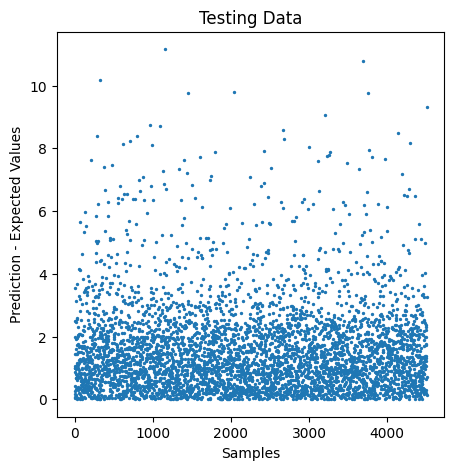

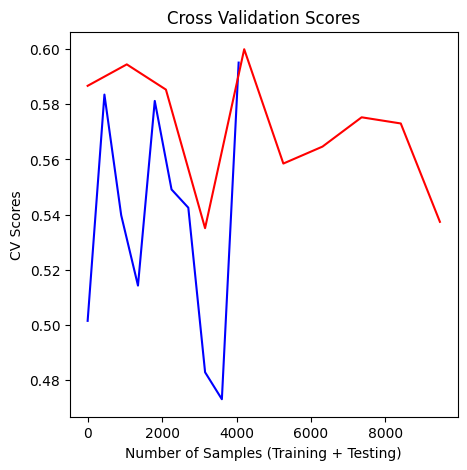

In [20]:
#running RandomForest with Updated bound

label = "duration of stay"

#time can be spent here finding optimal features
features = ["haemoglobin","leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide", "smoking ", 
           "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
           "heart failure", "complete heart block", "sick sinus", "kidney injury", "cerebrovascular accident",
           "atrial fibrillation", "ventricular tachycardia", "hypertension","coronary artery disease", "chronic kidney disease"
           ,"duration of intensive unit stay", "age", "diabetes mellitus"]

train_x, test_x, train_y, test_y = train_test_split(df_temp[features].values, df_temp[label].values, test_size = 0.3,\
                                                    random_state = 42)


#Random Forest Regression. Just use 70 estimators since it was the previous best. Higher estimators show no improvement
estimators =[70]

predictions = []
training_scores = []
testing_scores = []
test_predicts = []
for x in estimators:
        
    forest_reg = RandomForestRegressor(n_estimators = x, max_depth = 15, n_jobs = -1, random_state = 42)
    for_fit = forest_reg.fit(train_x, train_y)
    prediction_tr = for_fit.predict(train_x).astype("float64")
    prediction_te = for_fit.predict(test_x).astype("float64")

    #train_cv_score = -cross_val_score(forest_reg, train_x, train_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)
    #testing_cv_score = -cross_val_score(forest_reg, test_x, test_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)

    train_cv_score = cross_val_score(forest_reg, train_x, train_y, n_jobs = -1, cv = 10)
    testing_cv_score = cross_val_score(forest_reg, test_x, test_y, n_jobs = -1, cv = 10)


    training_scores.append(train_cv_score.copy())
    testing_scores.append(testing_cv_score.copy())
    test_predicts.append(prediction_te)

    print(f"Training Average CV Score Using {x} Estimators: ", np.average(train_cv_score))
    print(f"Training Error Margin Using {x} Estimators: ", mean_squared_error(prediction_tr, train_y))
    print()
    
    print(f"Testing Average CV Score Using {x} Estimators: ", np.average(testing_cv_score))
    print(f"Testing Error Margin Using {x} Estimators: ", mean_squared_error(prediction_te, test_y))
    print("\n")


plt.subplots(1, figsize = (5,5))
plt.title(f"Testing Data")
plt.xlabel("Samples")
plt.ylabel("Prediction - Expected Values")
plt.scatter(np.arange(0, len(prediction_te)) ,abs(prediction_te - test_y), s = 2)

plt.subplots(1, figsize = (5,5))
plt.title("Cross Validation Scores")
plt.ylabel("CV Scores")
plt.xlabel("Number of Samples (Training + Testing)")
plt.plot(np.arange(0, len(test_x), len(test_x)/len(testing_cv_score)) , testing_cv_score, color = "blue")
plt.plot(np.arange(0, len(train_x), len(train_x)/len(train_cv_score)) , train_cv_score, color = "red")
plt.plot()


The results above, after placing an upper bound on our data, show a significant improvement to the models error margin. The model shows and decrease of over 50% from ~9.1 to ~4.3 in the testing data. However, we see a decrease of CV scores from 61% to 54%. This may be from over-fitting as less data was used to train the model. Looking at the results, it seems a majority of the models predictions are now within 2 days of the actual.

## Predicting Admission Outcome with Logistic Regression

Here we will build a logistic regression model to predict the outcome of *EXPIRY* or *DISCHARGE* from the data. Since there are three possible values for 'outcome' we will consider the *DAMA* outcome (discharged against medical advice) to be a subset of the *DISCHARGE* outcome.

We want to explore what the most influential predictors for patient outcome are at the time of admission. By building a logistic regression model to predict outcome and analyzing the coefficients of the model we hope to better understand the relationship of the features and how they impact patient outcome.

First we will reset the dataframe to it's the state after the inital data cleaning by removing any unused features and standardizing the feature naming conventions.

In [36]:
# Reset dataframe
df = pd.read_csv('https://raw.githubusercontent.com/kateue/hospital_admission/main/HDHI%20Admission%20data.csv')

col_names = df.keys()

#lower case columns
col_names = [x.lower() for x in col_names]
df = df.set_axis(col_names, axis=1)

#drop features that may have no use (edit as needed)
unneeded_features = ["sno", "mrd no.", "d.o.a", "month year"]
if "sno" in df.keys():
    df.drop(unneeded_features, axis = 1, inplace = True)

#either do this or replace with mean/median of column. Could drop col like below
#make a simpleImputer and find numerical and categorical columns, and then make a pipeline

df.fillna(0, inplace = True)
df.replace("EMPTY", 0, inplace = True)

#clean names so they are more clear

unclear_feats = ["d.o.d", "dm", "htn", "cad", "prior cmp","ckd", "ef", "tlc", "bnp", "stemi", "hfref", "hfnef", "chb", "sss",
                    "aki","cva infract", "cva bleed", "af", "vt", "psvt", "uti", "dvt", 'hb', 'acs']

clear_feats = ["date of departure", "diabetes mellitus", "hypertension", "coronary artery disease", "prior metabolic panel",
                  "chronic kidney disease","ejection fraction", "leucocyte count", "brain natriuretic peptide", 
                  "myocardial infarction", "heart failure w/ reduced ejection","heart failure w/ normal ejection", "complete heart block", 
                  "sick sinus", "kidney injury", "cerebrovascular accident", "cerebrovascular accident",
                  "atrial fibrillation","ventricular tachycardia", "paroxysmal tachycardia",
                  "urinary tract infections", "vein thrombosis", 'haemoglobin','acute coronary syndrome']

for i in range(len(unclear_feats)):
    df.rename(columns = {unclear_feats[i] : clear_feats[i]}, inplace = True)


#normalize features
norm_feats = ["haemoglobin", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide",
           "ejection fraction", "duration of intensive unit stay"]

#pipeline
norm_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

df[norm_feats] = norm_pipeline.fit_transform(df[norm_feats])

outcome_df = df
outcome_df = outcome_df.drop('date of departure', axis=1)

### Exploration
Next we look at the distribution of our cleaned data to identify any potential outliers or largely skewed distributions. Once we have a better understanding of the numerical and categorical data we can consider further cleaning and transformations.

In [22]:
outcome_df['outcome'].value_counts()

DISCHARGE    13756
EXPIRY        1105
DAMA           896
Name: outcome, dtype: int64

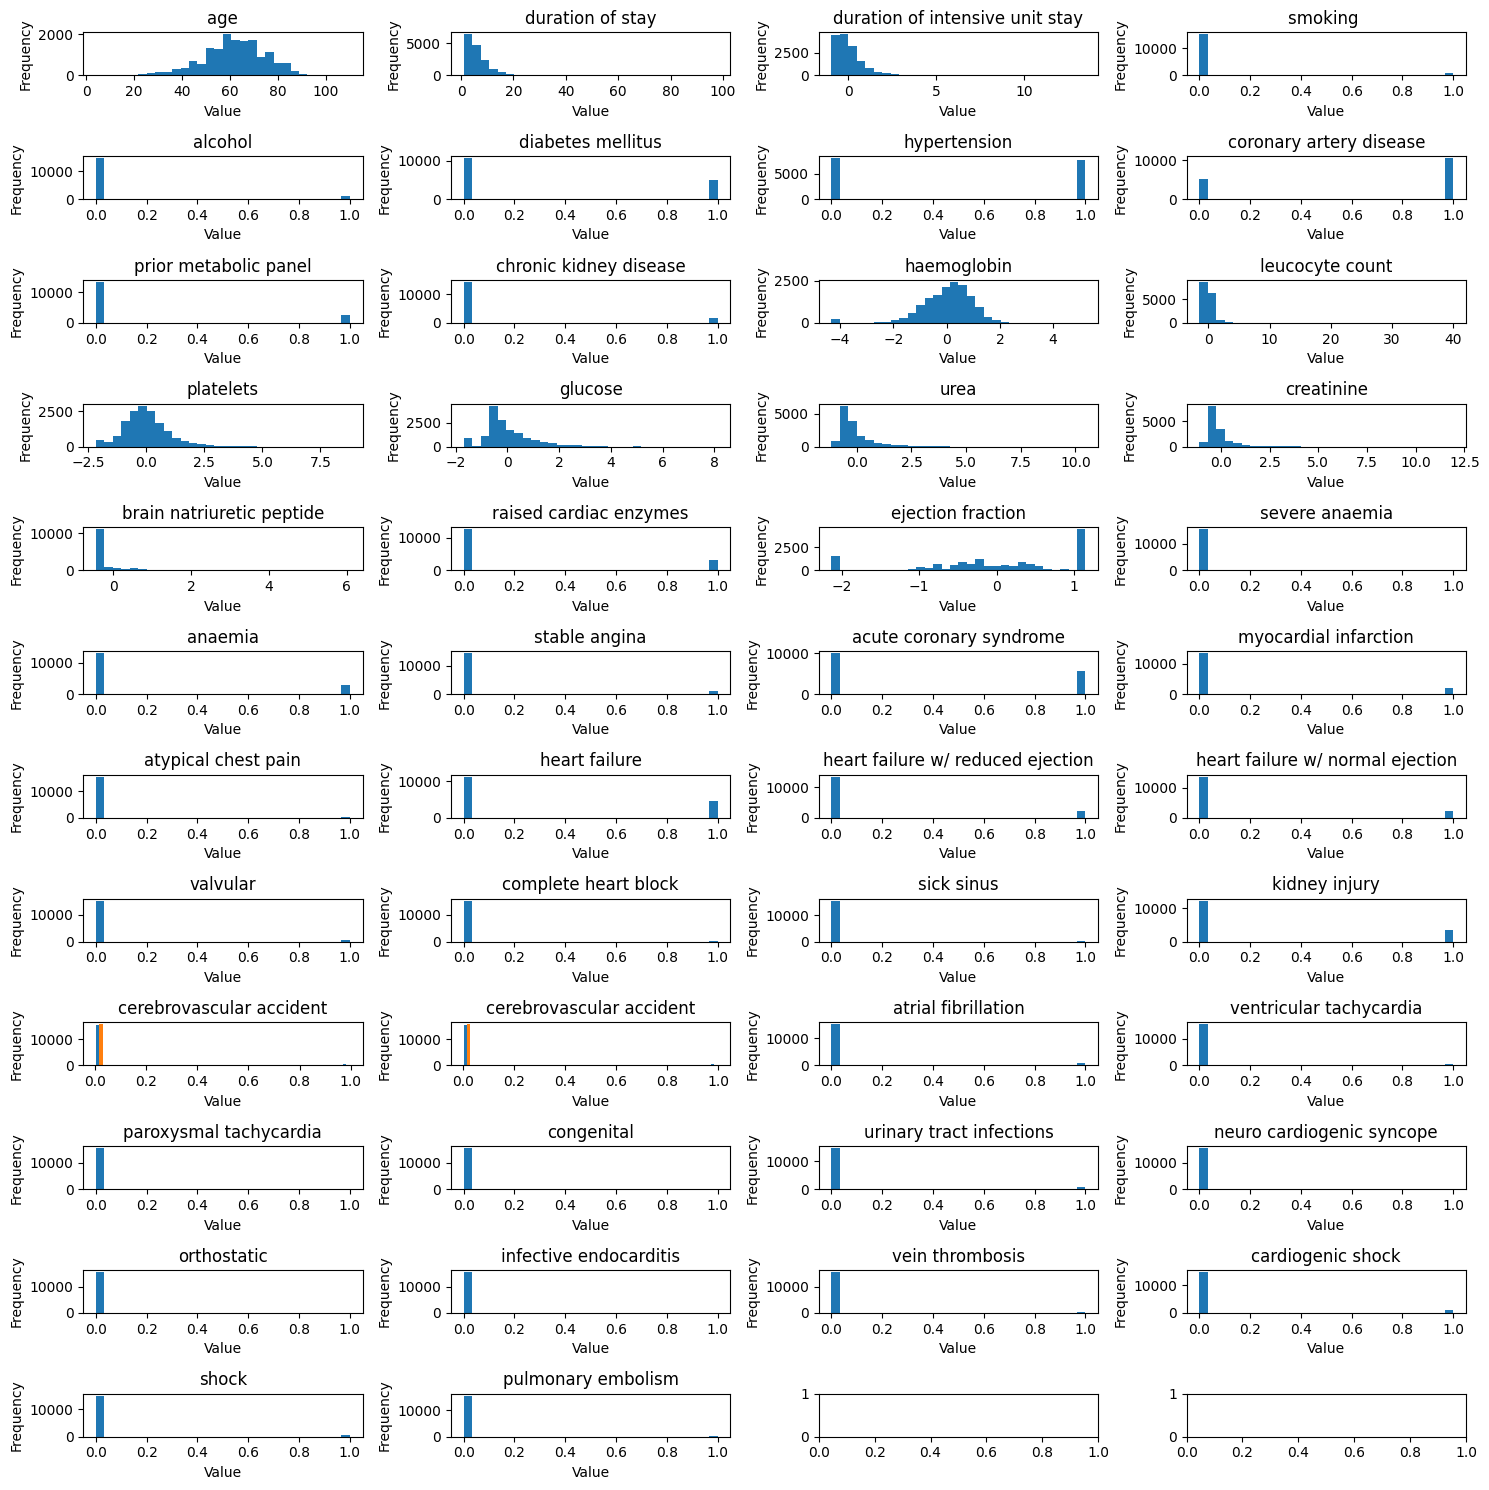

In [37]:
# Histogram of numerical features
df_numerical = outcome_df.select_dtypes(include=[np.number])

# Create a grid of 3x3 subplots
fig, subplots = plt.subplots(nrows=12, ncols=4, figsize=(15,15))

for i, column in enumerate(df_numerical.columns):
    row = i // 4
    col = i % 4
    subplot = subplots[row, col]
    subplot.hist(df_numerical[column].dropna(), bins=30)
    subplot.set_xlabel("Value")
    subplot.set_ylabel("Frequency")
    subplot.set_title(column)

plt.tight_layout()
plt.show()


Here we can see the distributions for each feature, with many of them being binary. The distributions for `[age, platelets, haemoglobin, ejection fraction]` all appear approximately normal.

Transforming `[duration of stay, duration of intensive unit stay, leucocyte count, glucose, urea]` might help normalize their distributions. We will start with a `sqrt` transformation.

For both the square root and logarithmic transformations we need to consider negative values and values of 0, therefore we will offset all our values by the minimum value of the column to ensure they are all greater than 0.

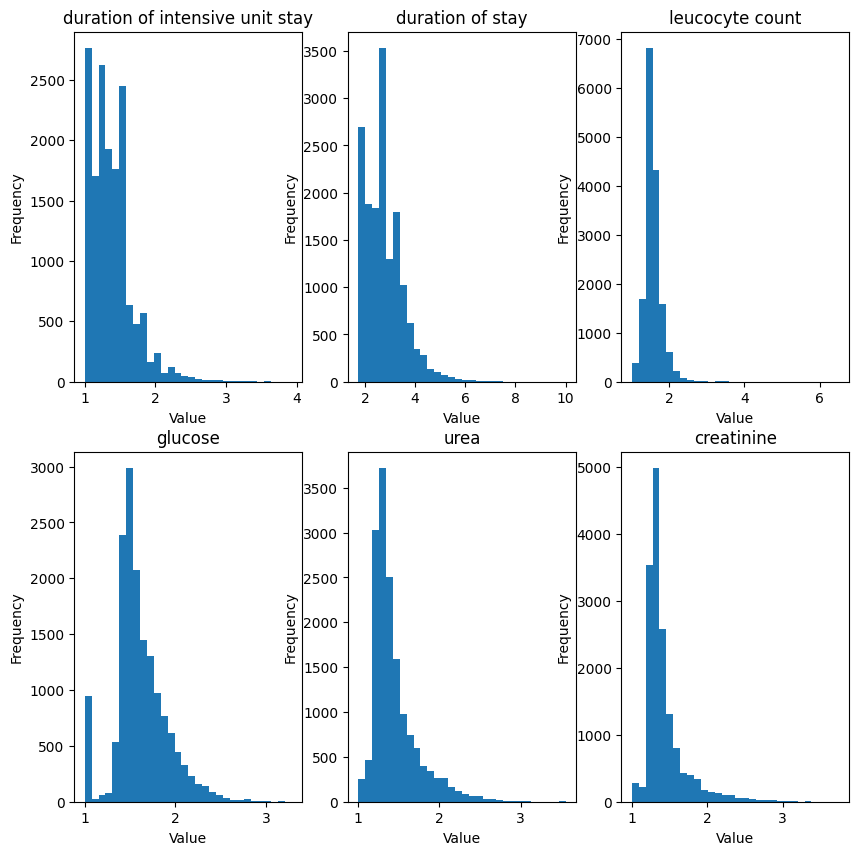

In [24]:
# Apply sqrt transformation
# sqrt doesn't like negative values so we add a constant  
# df['column'] = df['column'] + abs(df['column'].min()) + 1

sqrt_cols = [
    'duration of intensive unit stay',
    'duration of stay',\
    'leucocyte count',\
    'glucose',\
    'urea',\
    'creatinine',\
]

fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(10,10))

for i, column in enumerate(sqrt_cols):
    row = i // 3
    col = i % 3
    subplot = subplots[row, col]
    subplot.hist(np.sqrt(df_numerical[column] + abs(df_numerical[column].min()) + 1), bins=30)
    subplot.set_xlabel("Value")
    subplot.set_ylabel("Frequency")
    subplot.set_title(column)

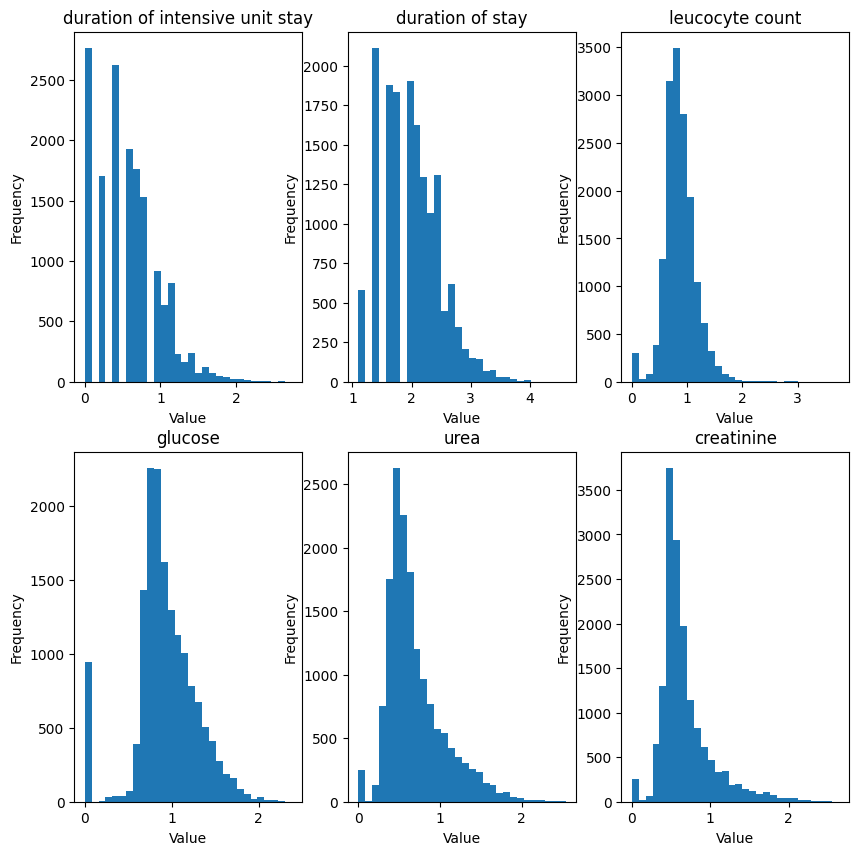

In [25]:
# We can also try applying the log transformation to see if it improves the distributions.
# Log cannot be applied to 0 or negative values, so we will need to add a constant to each value to make them positive.
log_cols = [
    'duration of intensive unit stay',
    'duration of stay',\
    'leucocyte count',\
    'glucose',\
    'urea',\
    'creatinine',\
]

fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(10,10))

for i, column in enumerate(log_cols):
    row = i // 3
    col = i % 3
    subplot = subplots[row, col]
    subplot.hist(np.log(df_numerical[column]+ abs(df_numerical[column].min()) + 1), bins=30)
    subplot.set_xlabel("Value")
    subplot.set_ylabel("Frequency")
    subplot.set_title(column)

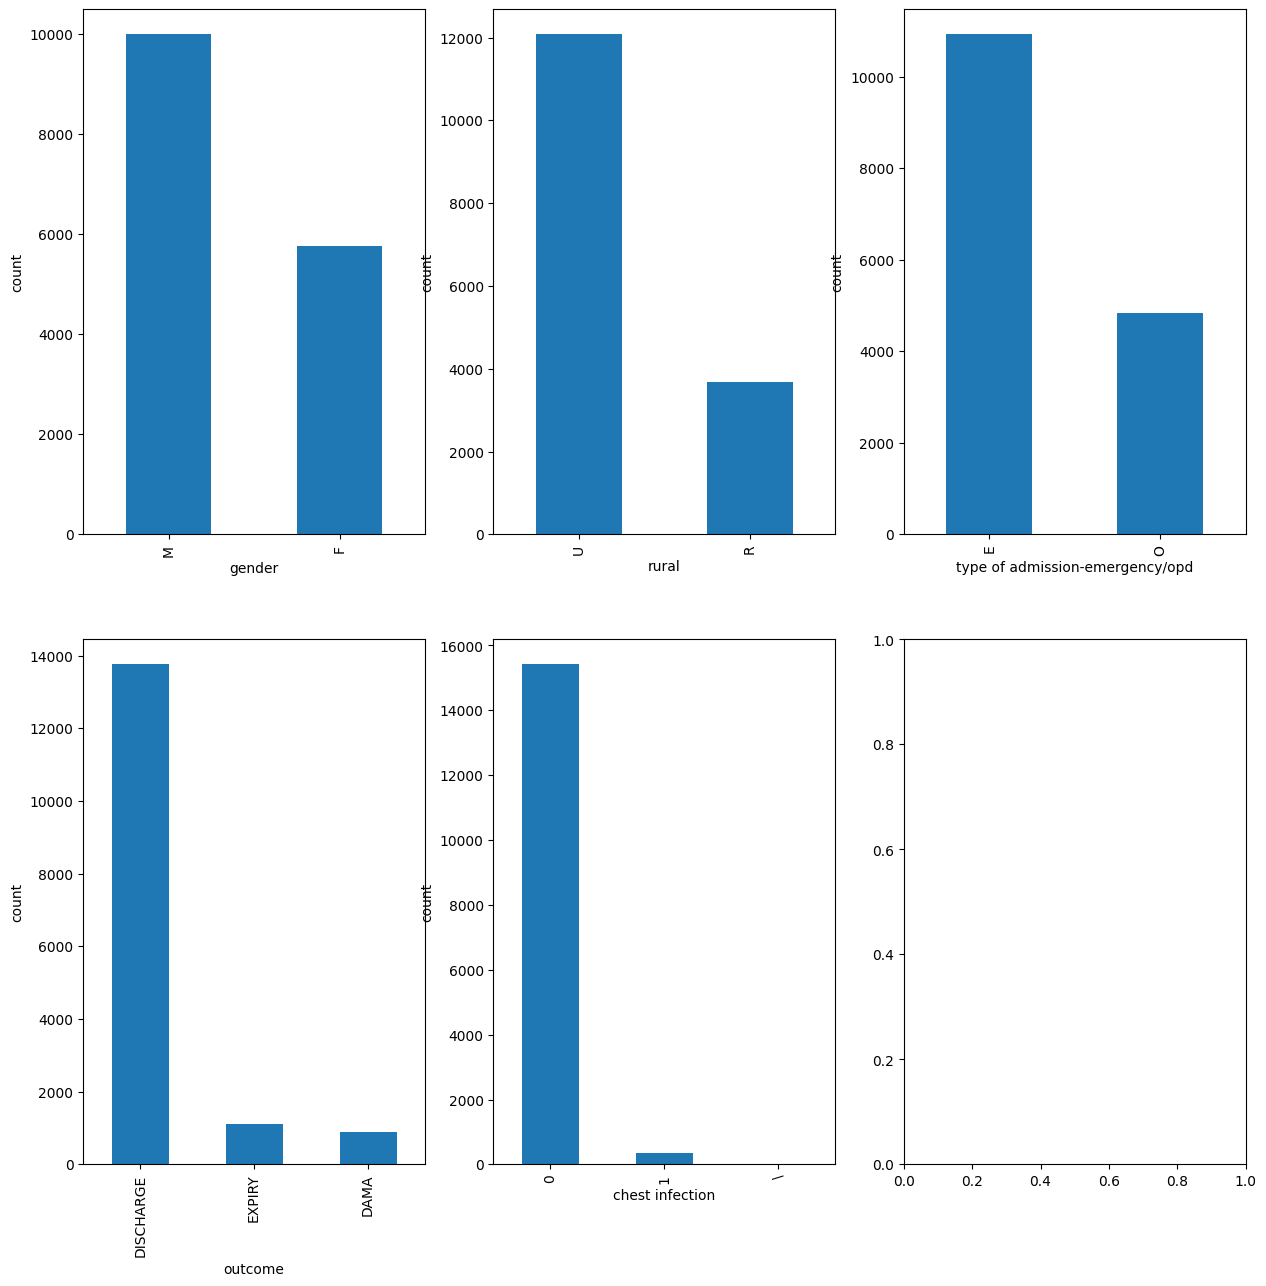

In [39]:
# Categorical bar plots
fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(15,15))

for i, column in enumerate(df_categorical.columns):
    row = i // 3
    col = i % 3
    subplot = subplots[row, col]
    df_categorical[column].value_counts().nlargest(10).plot(kind='bar', ax=subplot)
    subplot.set_xlabel(column)
    subplot.set_ylabel("count")

plt.show()

In [40]:
# we will combine DAMA and Discharge, since they are both discharges, also turning
# this into binary classification

outcome_df['outcome'] = outcome_df['outcome'].replace('DAMA', 'DISCHARGE')

# Setup pipelines for cat and num features
# We can also create a new feature by calculating percentage of time spent in the ICU 
from sklearn.preprocessing import FunctionTransformer

def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ["ratio"] # feature names out
  
# def log with offset function
def log_offset(X):
  return np.log(X + 4)

ratio_pipeline = make_pipeline(
      SimpleImputer(strategy="constant", fill_value=0),
      FunctionTransformer(column_ratio, feature_names_out=ratio_name), 
      StandardScaler())

log_pipeline = make_pipeline(
    # SimpleImputer(strategy="median"),
    FunctionTransformer(log_offset, feature_names_out="one-to-one"),
    StandardScaler())

cat_pipeline = make_pipeline(
    # SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

cat_features = outcome_df.drop('outcome', axis=1).select_dtypes(include=['object']).columns


preprocessing = ColumnTransformer(
    [("stay_per_icu_stay", ratio_pipeline, ["duration of stay", "duration of intensive unit stay"]),
     ("log", log_pipeline, [
        'duration of intensive unit stay',
        'duration of stay',
        'leucocyte count',
        'glucose',
        'urea',
        'creatinine',
    ]),
     ("cat", cat_pipeline, cat_features)],
     
     remainder=default_num_pipeline
)

outcome_prepared = preprocessing.fit_transform(outcome_df.drop('outcome', axis=1))

print(preprocessing.get_feature_names_out())

['stay_per_icu_stay__ratio' 'log__duration of intensive unit stay'
 'log__duration of stay' 'log__leucocyte count' 'log__glucose' 'log__urea'
 'log__creatinine' 'cat__gender_F' 'cat__gender_M' 'cat__rural_R'
 'cat__rural_U' 'cat__type of admission-emergency/opd_E'
 'cat__type of admission-emergency/opd_O' 'cat__chest infection_0'
 'cat__chest infection_1' 'cat__chest infection_\\' 'remainder__age'
 'remainder__smoking ' 'remainder__alcohol' 'remainder__diabetes mellitus'
 'remainder__hypertension' 'remainder__coronary artery disease'
 'remainder__prior metabolic panel' 'remainder__chronic kidney disease'
 'remainder__haemoglobin' 'remainder__platelets'
 'remainder__brain natriuretic peptide'
 'remainder__raised cardiac enzymes' 'remainder__ejection fraction'
 'remainder__severe anaemia' 'remainder__anaemia'
 'remainder__stable angina' 'remainder__acute coronary syndrome'
 'remainder__myocardial infarction' 'remainder__atypical chest pain'
 'remainder__heart failure' 'remainder__heart f

In [41]:
# Convert prepared data to dataframe
outcome_prepared_df = pd.DataFrame(outcome_prepared, columns=preprocessing.get_feature_names_out())

# add the outcome back to the dataframe
outcome_prepared_df['outcome'] = outcome_df['outcome']

<AxesSubplot: >

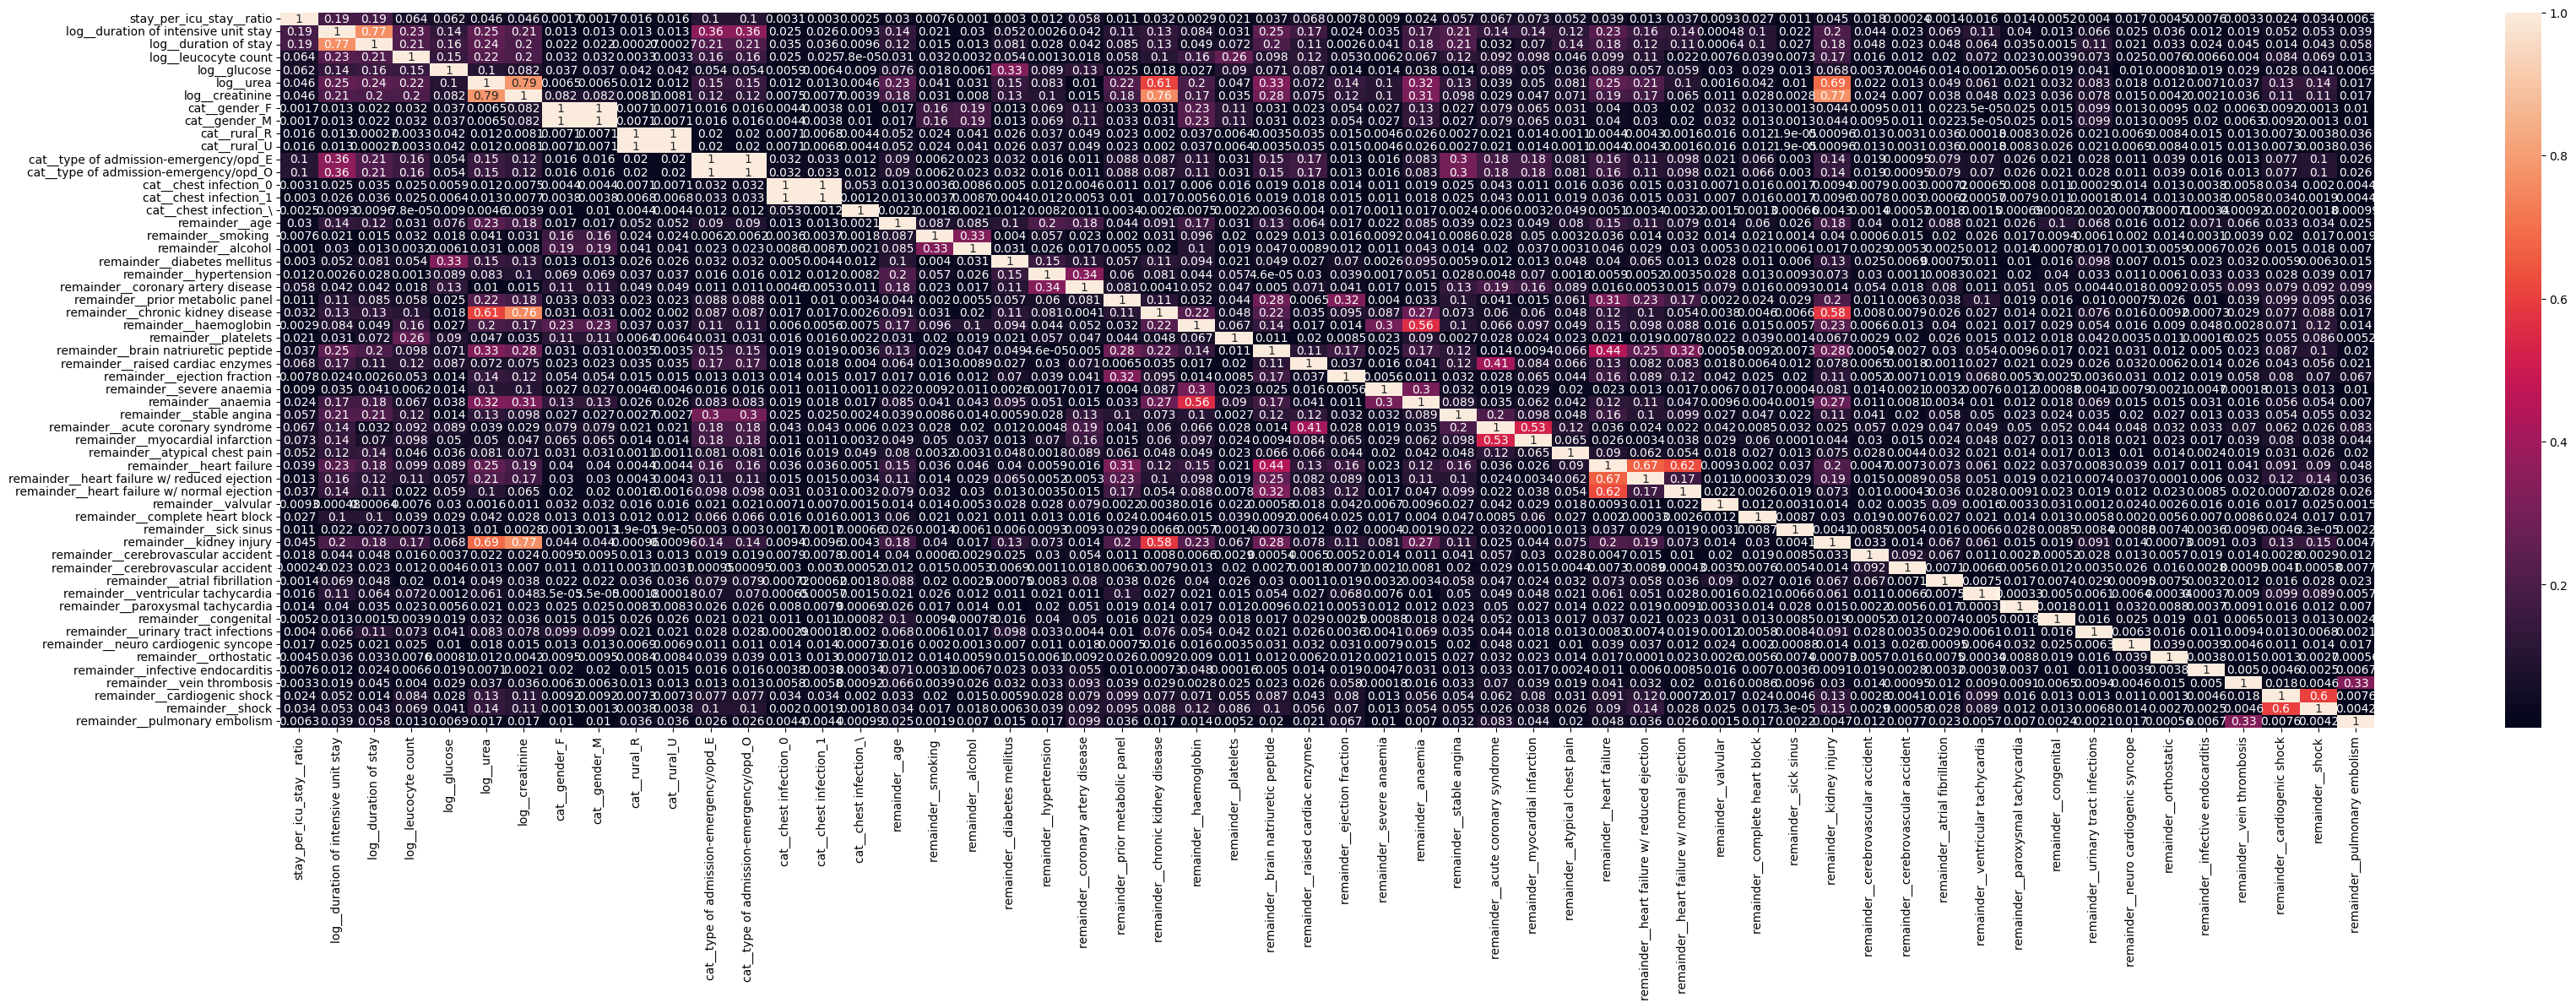

In [42]:
# Compute the correlation matrix for transformed data
corr_matrix = outcome_prepared_df.drop('outcome', axis=1).corr().abs()
plt.figure(figsize = (40, 11))
sns.heatmap(corr_matrix, annot = True)

Here we can see moderate correlations (~0.5-0.7) between some of the numerical attributes and the categorical ones, for example `corr(chronic kidney disease, urea) = 0.61`. For now we will try leaving these moderate correlations, setting a correlation drop threshold of 0.75.

In [43]:
# Now we want to drop highly correlated features. Select upper triangle of correlation matrix to iterate over
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

correlation_drop_threshold = 0.75

# Identify index of feature columns with correlation greater threshold
to_drop = [column for column in upper.columns if any(upper[column] > correlation_drop_threshold)]

# Drop features 
print("Dropping features: ")
for col in to_drop:
    print(col)

outcome_prepared_df_pruned = outcome_prepared_df.drop(outcome_prepared_df[to_drop], axis=1)

Dropping features: 
log__duration of stay
log__creatinine
cat__gender_M
cat__rural_U
cat__type of admission-emergency/opd_O
cat__chest infection_1
remainder__chronic kidney disease
remainder__kidney injury
remainder__cerebrovascular accident
remainder__cerebrovascular accident


In [44]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(outcome_prepared_df_pruned.drop('outcome', axis=1), outcome_prepared_df['outcome'], test_size=0.2, random_state=42)

log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

# Evaluate
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

Accuracy:  0.9574873096446701
Confusion Matrix: 
 [[2882   36]
 [  98  136]]
Classification Report: 
               precision    recall  f1-score   support

   DISCHARGE       0.97      0.99      0.98      2918
      EXPIRY       0.79      0.58      0.67       234

    accuracy                           0.96      3152
   macro avg       0.88      0.78      0.82      3152
weighted avg       0.95      0.96      0.95      3152



In [45]:
# We can find the optimal correlation threshold
corr_thresholds = [
    0.6,
    0.65,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
]

for corr_threshold in corr_thresholds:
    temp_to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    temp_df = outcome_prepared_df.drop(outcome_prepared_df[temp_to_drop], axis=1)

    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(temp_df.drop('outcome', axis=1), temp_df['outcome'], test_size=0.2, random_state=42)

    log_model_temp = LogisticRegression()

    log_model_temp.fit(X_train_temp, y_train_temp)

    y_pred_temp = log_model_temp.predict(X_test_temp)


    print("Correlation Threshold: ", corr_threshold)
    print("Accuracy: ", round(accuracy_score(y_test_temp, y_pred_temp),4))
    print("Confusion Matrix: \n", confusion_matrix(y_test_temp, y_pred_temp))
    print("Classification Report: \n", classification_report(y_test_temp, y_pred_temp))
    print("")
    # print("--------------------")


Correlation Threshold:  0.6
Accuracy:  0.9473
Confusion Matrix: 
 [[2876   42]
 [ 124  110]]
Classification Report: 
               precision    recall  f1-score   support

   DISCHARGE       0.96      0.99      0.97      2918
      EXPIRY       0.72      0.47      0.57       234

    accuracy                           0.95      3152
   macro avg       0.84      0.73      0.77      3152
weighted avg       0.94      0.95      0.94      3152


Correlation Threshold:  0.65
Accuracy:  0.9575
Confusion Matrix: 
 [[2882   36]
 [  98  136]]
Classification Report: 
               precision    recall  f1-score   support

   DISCHARGE       0.97      0.99      0.98      2918
      EXPIRY       0.79      0.58      0.67       234

    accuracy                           0.96      3152
   macro avg       0.88      0.78      0.82      3152
weighted avg       0.95      0.96      0.95      3152


Correlation Threshold:  0.7
Accuracy:  0.9575
Confusion Matrix: 
 [[2882   36]
 [  98  136]]
Classification

We will drop only strongly correlated pairs in order to lose minimal information, choosing a threshold of 0.95. If we are overfitting later we can lower this threshold. Notice the low recall value of 0.62 for predicting the expiry of a patient.

In [46]:
# construct the model again with threshold = 0.95
corr_threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
temp_df = outcome_prepared_df.drop(outcome_prepared_df[to_drop], axis=1)

X_train, X_test, y_train, y_test = train_test_split(temp_df.drop('outcome', axis=1), temp_df['outcome'], test_size=0.2, random_state=42)

log_model = LogisticRegression()

log_model.fit(X_train, y_train)

LogisticRegression()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


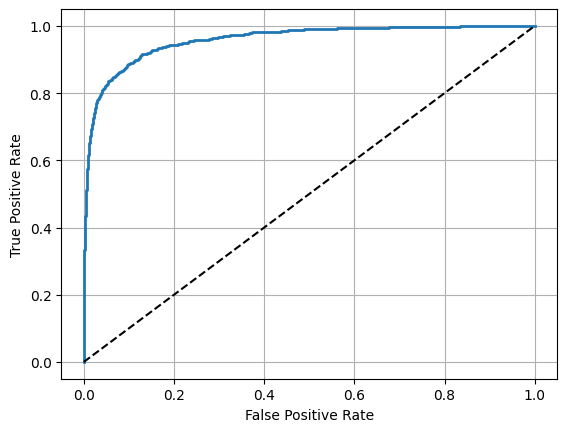

In [47]:
# build roc curve using cross_val_predict
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

y_scores = cross_val_predict(log_model, X_train, y_train, cv=10, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train, y_scores, pos_label="EXPIRY")

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

plot_roc_curve(fpr, tpr)

Based on the ROC curve shown above, the model is performing well. We should test for overfitting. We will use cross validation and plotting the learning curves to compare the training error and validation error.

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

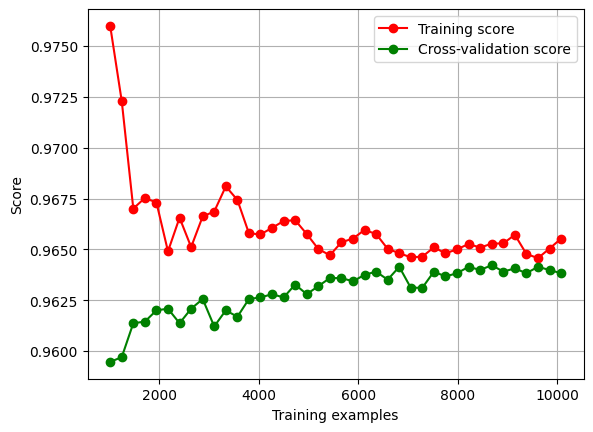

In [48]:
# plot the learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    log_model, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 40))

def plot_learning_curve(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="upper right")
    plt.grid()

plot_learning_curve(train_sizes, train_scores, test_scores)


The learning curves are converging around 0.964, indicating the model is neither underfit nor overfit.

We have explored and constructed a successful logistic regression model for predicting the outcome of a hospital admission with an accuracy of 0.96.

In [49]:
# Now to finally answer our question of what the biggest predictors are, we can look at the coefficients of the logistic regression model.
coef = log_model.coef_[0]

# match coefficients to features
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': coef})

feature_importance['importance_scaled'] = np.abs(feature_importance['importance'])

# Sort by abs val
feature_importance = feature_importance.sort_values(by='importance_scaled', ascending=False)
print(feature_importance[:5])
print("...")


                                   feature  importance  importance_scaled
9   cat__type of admission-emergency/opd_E    2.016691           2.016691
2                    log__duration of stay   -1.629178           1.629178
1     log__duration of intensive unit stay    1.082941           1.082941
10                  cat__chest infection_0    0.867152           0.867152
48                        remainder__shock    0.791507           0.791507
...


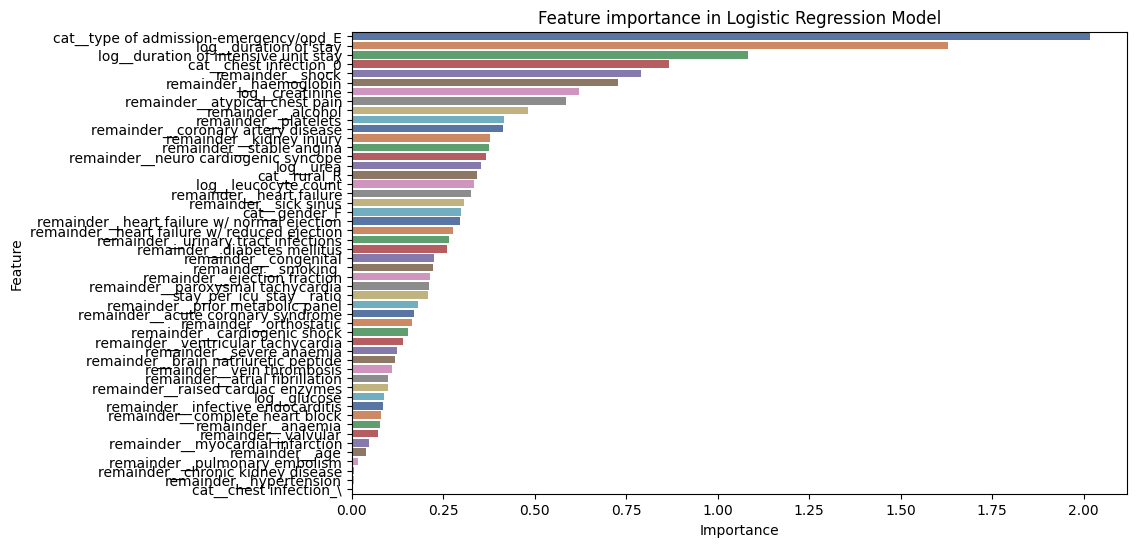

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance_scaled', y='feature', palette='deep')
plt.title('Feature importance in Logistic Regression Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Above displays the order of importance for each feature used in our model by ranking the absolute value of the feature's coefficient. Based on the logistic regression model we constructed, the 5 most influential predictors of the patient's outcome (excluding duration of stay) are:

1. Emergency admissions
2. Chest infections
3. Shock
4. Haemoglobin
5. Creatinine

In the future it might be useful to apply the following to further explore this dataset:
1. Handling non-existent values that are filled as 0 for certain numerical attributes in the data preprocessing
2. Exploring the effect of stratified sampling on the model
3. Using a more effective model (eg. RandomForest) to rank the importance of features on outcome

## Predict Heart Failure

Just a final quick model to predict heart failure in a patient. This will not be explored deeply as time is short. This model uses the same features as duration of stay, but will also include blood tests, gender, and age. The first model we used will be random forest, as it had the best results in the duration of stay model. The model achieves a CV score of ~81%, with a low error margin. Other results include:

Acc: 80.52030456852792
F1: 58.865564984368014
Recall: 48.13732651570489
Precision: 75.74712643678161
R2 Score: 5.305741843321399

In [51]:
# Reset dataframe
df = pd.read_csv('https://raw.githubusercontent.com/kateue/hospital_admission/main/HDHI%20Admission%20data.csv')

col_names = df.keys()

#lower case columns
col_names = [x.lower() for x in col_names]
df = df.set_axis(col_names, axis=1)

#drop features that may have no use (edit as needed)
unneeded_features = ["sno", "mrd no.", "d.o.a", "month year"]
if "sno" in df.keys():
    df.drop(unneeded_features, axis = 1, inplace = True)

#either do this or replace with mean/median of column. Could drop col like below
#make a simpleImputer and find numerical and categorical columns, and then make a pipeline

#df.fillna(0, inplace = True)
df.replace("EMPTY", None, inplace = True)

#clean names so they are more clear

unclear_feats = ["d.o.d", "dm", "htn", "cad", "prior cmp","ckd", "ef", "tlc", "bnp", "stemi", "hfref", "hfnef", "chb", "sss",
                    "aki","cva infract", "cva bleed", "af", "vt", "psvt", "uti", "dvt", 'hb', 'acs']

clear_feats = ["date of departure", "diabetes mellitus", "hypertension", "coronary artery disease", "prior metabolic panel",
                  "chronic kidney disease","ejection fraction", "leucocyte count", "brain natriuretic peptide", 
                  "myocardial infarction", "heart failure w/ reduced ejection","heart failure w/ normal ejection", "complete heart block", 
                  "sick sinus", "kidney injury", "cerebrovascular accident", "cerebrovascular accident",
                  "atrial fibrillation","ventricular tachycardia", "paroxysmal tachycardia",
                  "urinary tract infections", "vein thrombosis", 'haemoglobin','acute coronary syndrome']

for i in range(len(unclear_feats)):
    df.rename(columns = {unclear_feats[i] : clear_feats[i]}, inplace = True)


#normalize features
norm_feats = ["haemoglobin", "leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide",
           "ejection fraction", "duration of intensive unit stay"]

#pipeline
norm_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

df[norm_feats] = norm_pipeline.fit_transform(df[norm_feats])


Training Average CV Score Using 20 Estimators:  0.8053302081602232
Training Error Margin Using 20 Estimators:  0.060567594523528875

Testing Average CV Score Using 20 Estimators:  0.7874363958863367
Testing Error Margin Using 20 Estimators:  0.19331641285956006


Training Average CV Score Using 30 Estimators:  0.808866677745729
Training Error Margin Using 30 Estimators:  0.059842234110073445

Testing Average CV Score Using 30 Estimators:  0.7889216863152615
Testing Error Margin Using 30 Estimators:  0.188663282571912


Training Average CV Score Using 40 Estimators:  0.8092291605306761
Training Error Margin Using 40 Estimators:  0.05757548281802521

Testing Average CV Score Using 40 Estimators:  0.7906121224065646
Testing Error Margin Using 40 Estimators:  0.19077834179357023


Training Average CV Score Using 50 Estimators:  0.8089569282257759
Training Error Margin Using 50 Estimators:  0.057394142714661346

Testing Average CV Score Using 50 Estimators:  0.7916709965241696
Testing Error

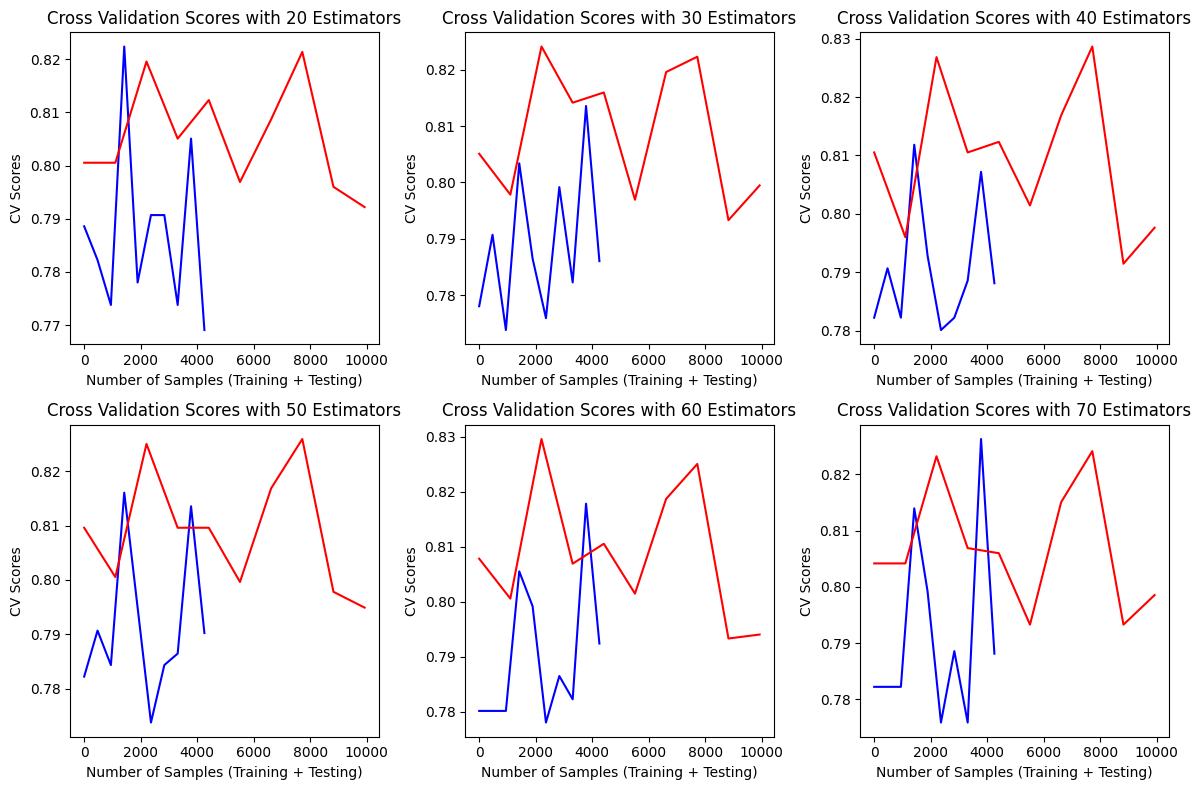

In [52]:
label = "heart failure"

#time can be spent here finding optimal features
features = ["haemoglobin","leucocyte count", "platelets", "glucose", "urea", "creatinine", "brain natriuretic peptide", "smoking ", 
           "alcohol", "severe anaemia", "anaemia", "chronic kidney disease", "myocardial infarction", "atypical chest pain",
            "complete heart block", "sick sinus", "kidney injury", "cerebrovascular accident",
           "atrial fibrillation", "ventricular tachycardia", "hypertension","coronary artery disease", "chronic kidney disease"
           ,"duration of intensive unit stay", "age", "diabetes mellitus", "infective endocarditis", "vein thrombosis", 
           "cardiogenic shock", "pulmonary embolism", "raised cardiac enzymes", "gender"]

df[features[-1]] = LabelEncoder().fit_transform(df[features[-1]])

train_x, test_x, train_y, test_y = train_test_split(df[features].values, df[label].values, test_size = 0.3,\
                                                    random_state = 42)

#Random Forest Regression
estimators =[20,30,40,50,60,70]

predictions = []
training_scores = []
testing_scores = []
test_predicts = []
for x in estimators:
        
    forest_class = RandomForestClassifier(n_estimators = x, max_depth = 15, n_jobs = -1, random_state = 42)
    for_fit = forest_class.fit(train_x, train_y)
    prediction_tr = for_fit.predict(train_x).astype("float64")
    prediction_te = for_fit.predict(test_x).astype("float64")

    #train_cv_score = -cross_val_score(forest_class, train_x, train_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)
    #testing_cv_score = -cross_val_score(forest_class, test_x, test_y, n_jobs = -1, scoring="neg_root_mean_squared_error", cv = 10)

    train_cv_score = cross_val_score(forest_class, train_x, train_y, n_jobs = -1, cv = 10)
    testing_cv_score = cross_val_score(forest_class, test_x, test_y, n_jobs = -1, cv = 10)


    training_scores.append(train_cv_score.copy())
    testing_scores.append(testing_cv_score.copy())
    test_predicts.append(prediction_te)

    print(f"Training Average CV Score Using {x} Estimators: ", np.average(train_cv_score))
    print(f"Training Error Margin Using {x} Estimators: ", mean_squared_error(prediction_tr, train_y))
    print()
    
    print(f"Testing Average CV Score Using {x} Estimators: ", np.average(testing_cv_score))
    print(f"Testing Error Margin Using {x} Estimators: ", mean_squared_error(prediction_te, test_y))
    print("\n")

# fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

# for i in range(len(test_predicts)):
#     row = i // 3
#     col = i % 3

#     subplot = subplots[row, col]
#     subplot.scatter(np.arange(0, len(test_predicts[i])), 
#     abs(test_predicts[i]-test_y), s=2)
#     subplot.set_xlabel("Samples")
#     subplot.set_ylabel("Prediction - Expected Value")
#     subplot.set_title(f"Testing Data Using {estimators[i]} Estimators")

# plt.tight_layout()
# plt.show()

fig, subplots = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

for i in range(len(testing_scores)):
    row = i // 3
    col = i % 3

    subplot = subplots[row, col]
    subplot.plot(np.arange(0, len(test_x), len(test_x)/len(testing_scores[i])) , testing_scores[i], color = "blue")
    subplot.plot(np.arange(0, len(train_x), len(train_x)/len(training_scores[i])) , training_scores[i], color = "red")
    subplot.set_xlabel("Number of Samples (Training + Testing)")
    subplot.set_ylabel("CV Scores")
    subplot.set_title(f"Cross Validation Scores with {estimators[i]} Estimators")

plt.tight_layout()
plt.show()

Acc: 80.52030456852792
F1: 58.865564984368014
Recall: 48.13732651570489
Precision: 75.74712643678161
R2 Score: 5.305741843321399


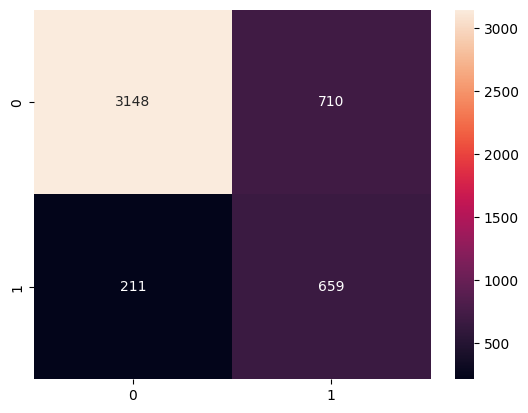

In [53]:
from sklearn import metrics
print('Acc:', metrics.accuracy_score(test_y, prediction_te) * 100)
print('F1:', metrics.f1_score(test_y, prediction_te) * 100)
print('Recall:', metrics.recall_score(test_y, prediction_te) * 100)
print('Precision:', metrics.precision_score(test_y, prediction_te) * 100)
print('R2 Score:', metrics.r2_score(test_y, prediction_te) * 100)
sns.heatmap(metrics.confusion_matrix(prediction_te, test_y), annot=True, fmt='g');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b1b25a3b-4f14-41fa-903c-0f643cf1df5c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>